In [1]:
import tensorflow as tf

In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [43]:
%%capture
import pandas as pd
import numpy as np
import scipy
import pywt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import IPython
import IPython.display
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy
import math
import warnings
from numba import jit, cuda
warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
pd.set_option('display.max_columns', None)

In [44]:
%cd C:/Users/choco/OneDrive/DARIO Computador/UnB/Disciplinas/Fundamentos de sistemas eólicos/Furnas AP
#%cd D:/Users/Dario/OneDrive/DARIO Computador/UnB/Disciplinas/Fundamentos de sistemas eólicos/Furnas AP

C:\Users\choco\OneDrive\DARIO Computador\UnB\Disciplinas\Fundamentos de sistemas eólicos\Furnas AP


In [45]:
#Colocar o arquivo do Nasa Power com média horária na mesma pasta que o script
ap_data = pd.read_csv('./POWER_Point_Hourly_20010101_20220331.csv', sep=',', header=10)

In [46]:
#Converte columnas YY-MO-DY ao formato datetime
ap_data.columns = ["Year", "Month", "Day", "Hour", "Wind Direction", "Wind Speed"]
#ap_data.head(5)

In [47]:
ap_data['Date'] = pd.to_datetime(ap_data[['Year','Month', 'Day', 'Hour']])
ap_data.set_index('Date', inplace=True) # inplace implementa o set index
ap_data['DoY'] = ap_data.index.dayofyear
ap_data.reset_index(inplace=True)
ap_data.insert(0, 'HoY', (ap_data.DoY-1)*24 + ap_data.Hour)
ap_data.set_index(['DoY', 'HoY', 'Date'], inplace=True)
#ap_data.head(10)

In [48]:
ws_meanxhora = ap_data['Wind Speed'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
#ws_meanxhora = ws_meanxhora[:-640]
#ws_meanxhora

In [53]:
tt=list(ws_meanxhora["Wind Speed"])
wavelet = pywt.Wavelet('db2')
vect_coeffs=[]
input_step_time = 128
pywt.swt_max_level(len(tt[0:input_step_time]))

7

In [50]:
wavelet

pywt._extensions._pywt.Wavelet(name='db2', filter_bank=([-0.12940952255126037, 0.2241438680420134, 0.8365163037378079, 0.48296291314453416], [-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037], [0.48296291314453416, 0.8365163037378079, 0.2241438680420134, -0.12940952255126037], [-0.12940952255126037, -0.2241438680420134, 0.8365163037378079, -0.48296291314453416]))

In [51]:
l=len(tt)
total_samples = l/input_step_time
total_samples

1455.0

In [52]:
#del vect_coeffs

In [54]:
for i in range(l-input_step_time):
    coeffs = pywt.swt(tt[i:i+input_step_time], wavelet, level=4, trim_approx=True, norm=True)
    coeffs = list(coeffs)
    vect_coeffs.append(coeffs)

In [ ]:
coeffs

In [17]:
len(vect_coeffs)

186112

In [18]:
len(tt)

186240

In [55]:
d=[i for i in range(len(tt))]

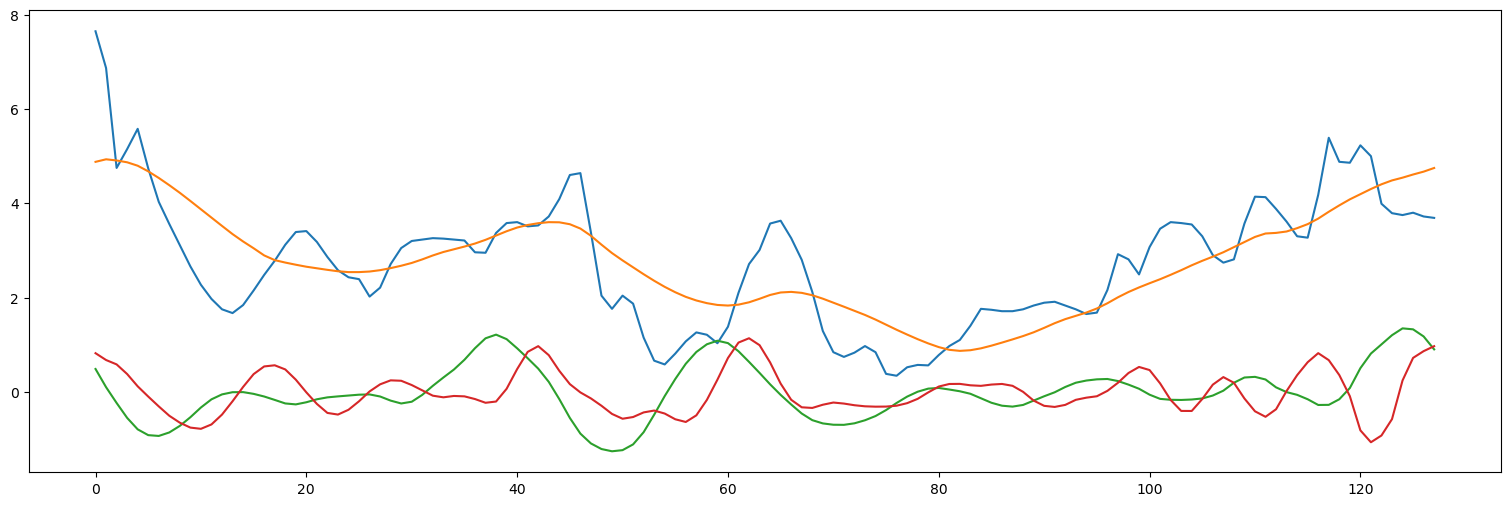

In [16]:
plt.style.use('default')
plt.figure(figsize=(19,6))
plt.plot(d[0:128],          tt[128:256])
plt.plot(d[0:128], vect_coeffs[128][0])
plt.plot(d[0:128], vect_coeffs[128][1])
plt.plot(d[0:128], vect_coeffs[128][2])
#plt.plot(d[0:128], vect_coeffs[128][3])
#plt.plot(d[0:128], vect_coeffs[128][4])

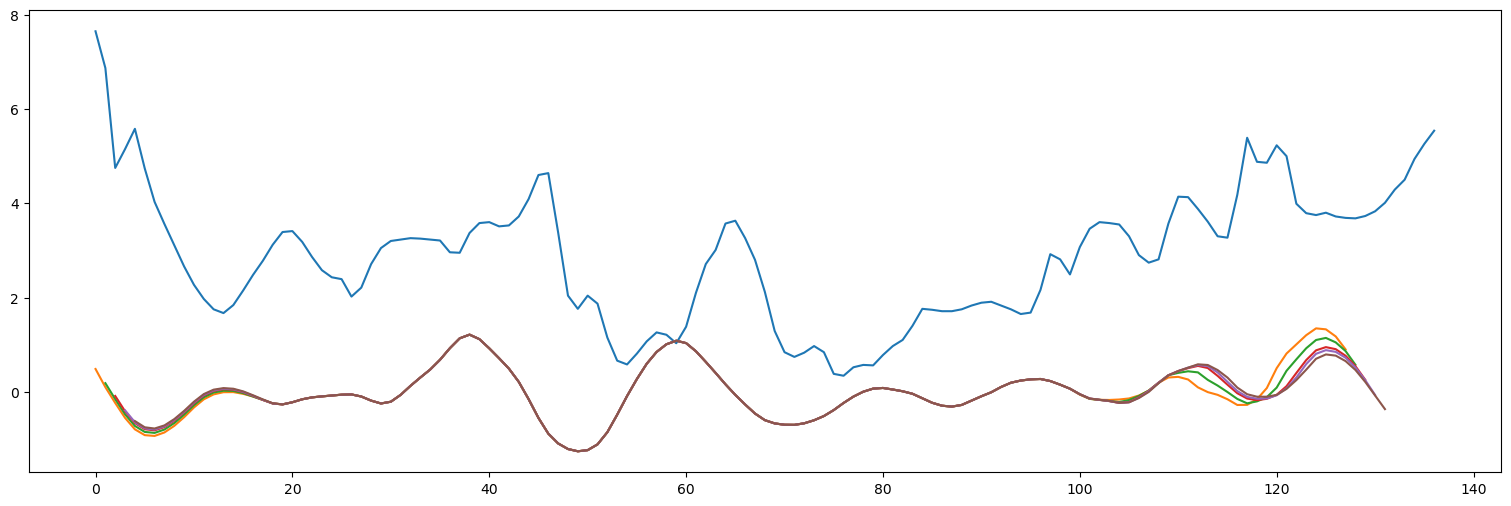

In [21]:
plt.style.use('default')
plt.figure(figsize=(19,6))
plt.plot(d[0:137],          tt[128:265])
plt.plot(d[0:128], vect_coeffs[128][1])
plt.plot(d[1:129], vect_coeffs[129][1])
plt.plot(d[2:130], vect_coeffs[130][1])
plt.plot(d[3:131], vect_coeffs[131][1])
plt.plot(d[4:132], vect_coeffs[132][1])
#plt.plot(d[0:128], vect_coeffs[0][5])
#plt.plot(d[0:32], coeffs[6][0:32])
#plt.plot(d[0:32], coeffs[7][0:32])
#plt.plot(d[0:32], coeffs[8][0:32])

In [32]:
vect_coeffs = np.array(vect_coeffs)
vect_coeffs.shape

(186112, 5, 128)

In [33]:
vect_coeffs_reshape = vect_coeffs.transpose((0,2,1)) #Para fazer a transposição das matrizes na dimensão 0 (como quando você está transpondo
vect_coeffs_reshape.shape                            #  matrizes onde 0 é a dimensão do lote), você deve definir axes (0,2,1]).

(186112, 128, 5)

In [34]:
target_y = np.array(tt[128:])
target_y = target_y.reshape((len(target_y),1,1))
target_y.shape

(186112, 1, 1)

In [20]:
186112-split

NameError: name 'split' is not defined

In [35]:
split = int(len(vect_coeffs_reshape)*0.7)
#Coeficientes
train_x = vect_coeffs_reshape[0:split]
teste_x = vect_coeffs_reshape[split:]#split+25000]
#val_x   = vect_coeffs_reshape[split+25000:]
train_y = target_y[0:split]
teste_y = target_y[split:]#split+25000]
#val_y   = target_y[split+25000:]

In [36]:
AAA = [tt[i:i+128] for i in range(split)]

In [37]:
BBB = [tt[i:i+128] for i in range(split,l-128)]
#CCC = [tt[i:i+128] for i in range(split+25000,l-128)]

In [38]:
# serie original
AAA = np.array(AAA).reshape((split, input_step_time, 1))
BBB = np.array(BBB).reshape((len(teste_x), input_step_time, 1))
#CCC = np.array(CCC).reshape((len(val_x), input_step_time, 1))
BBB.shape

(55834, 128, 1)

In [39]:
train_x_with_original = np.concatenate((train_x, AAA), axis=2)
teste_x_with_original = np.concatenate((teste_x, BBB), axis=2)
#val_x_with_original   = np.concatenate((val_x, CCC), axis=2)
teste_x_with_original.shape

(55834, 128, 6)

In [26]:
teste_x.shape

(55834, 128, 5)

In [22]:
%%capture
!pip install -q -U keras-tuner
import keras_tuner as kt

In [27]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mape',
                     max_epochs=100,
                     factor=9,
                     hyperband_iterations=100 * (math.log(100, 30) ** 2),
                     directory='/content/drive/MyDrive/',
                     project_name='Hiperband_GRU',
                     )

In [155]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_mape',
                     overwrite=True,
                     directory='/content/drive/MyDrive/',
                     project_name='Hiperband_GRU',
                     )

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mape', patience=5, mode='auto')
tuner.search(AAA, train_y,  validation_data=(CCC, val_y), epochs=100, batch_size=512, callbacks=[checkpoint, early_stopping])

NameError: name 'tuner' is not defined

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [90]:
tuner.reload()
trials = tuner.oracle.trials

# Print out the ID and the score of all trials
##for trial_id, trial in trials.items():
  ##     print(trial_id, trial.hyperparameters.values)

best_trials = tuner.oracle.get_best_trials(num_trials=1)
trial in best_trials
trial.summary()

Trial 0033 summary
Hyperparameters:
units: 144
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 8.706291198730469


In [74]:
l_r = trial.hyperparameters.values['learning_rate']

In [50]:
model_SWT_GRU_only_serie = tuner.load_model(trial)

In [ ]:
keras.utils.plot_model(model, "model.png", show_shapes=True, dpi=80)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

Ver esse link para entender os weights da GRU
https://stackoverflow.com/questions/72809642/how-to-interpret-get-weights-for-keras-gru

In [ ]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
weights = np.array(model.get_layer('gru_36').get_weights())
weights[2].shape

(2, 384)

In [ ]:
model.evaluate(teste_x, teste_y, verbose=0)

[0.11525478959083557,
 0.21878822147846222,
 7.972073078155518,
 0.11525478959083557,
 0.9754337668418884]

In [ ]:
predict_y = model.predict(teste_x, verbose=0)

In [ ]:
def plot_result(testY, test_predict):
    #actual = np.append(trainY, testY)
    #predictions = np.append(train_predict, test_predict)
    rows = len(testY)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.scatter(range(rows), testY,  marker='.', zorder=10)
    plt.scatter(range(rows), test_predict, marker='x')
    #plt.axvline(x=len(testY), color='r')
    #plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title ('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')


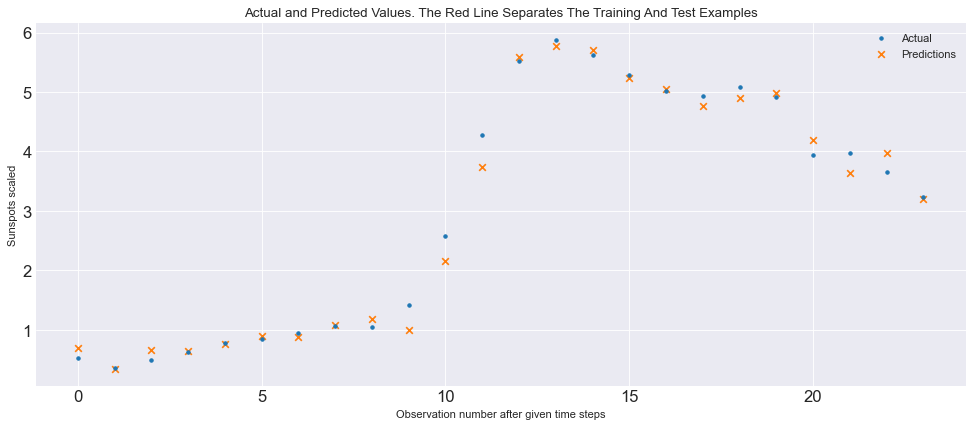

In [ ]:
plot_result(teste_y.reshape(len(teste_y))[24:48], predict_y.reshape(len(teste_y))[24:48])

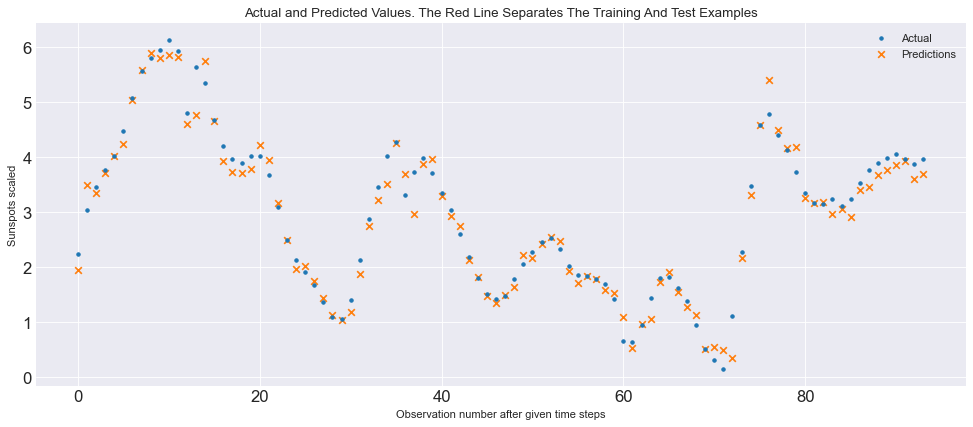

In [ ]:
plot_result(teste_y.reshape(len(teste_y))[2000:2094], predict_y.reshape(len(teste_y))[2000:2094])

# coef + time serie original

In [31]:
OUT_STEPS = 1
model_with_original = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.GRU(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, 1])
        ])

In [32]:
history = compile_and_fit(model_with_original, train_x_with_original, train_y)

NameError: name 'compile_and_fit' is not defined

In [ ]:
predict_y = model_with_original.predict(teste_x_with_original, verbose=0)

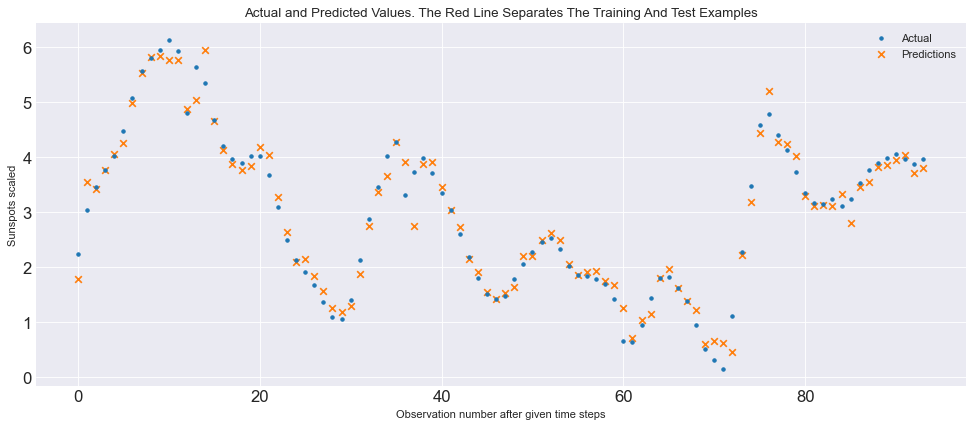

In [ ]:
plot_result(teste_y.reshape(len(teste_y))[2000:2094], predict_y.reshape(len(teste_y))[2000:2094])

# Only GRU model

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend as K
@jit
def mean_bias_error(y_true, y_pred):
    mbe = K.mean(y_true - y_pred)
    return mbe
@jit
def chi_square(y_true, y_pred):
    Chi_2 = K.sum((y_true - y_pred)**2)/y_true
    return Chi_2
    
MAX_EPOCHS = 200
@jit
def compile_and_fit(model, x_train, y_train, model_path, patience=30):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mape',
                                                      patience=patience,
                                                      mode='auto')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  metrics=['mae', 'mape', 'msle', 'logcosh', chi_square, mean_bias_error,
                            keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])

    checkpoint = ModelCheckpoint(model_path, monitor='val_mape', verbose=1, save_best_only=True)
    history = model.fit(x_train, y_train, epochs=MAX_EPOCHS, batch_size=256,
                        validation_split = 0.2,
                        callbacks=[checkpoint, early_stopping])
    return history

In [26]:
train_x_only_original = AAA
teste_x_only_original = BBB
print(train_x_only_original.shape, teste_x_only_original.shape)

(130278, 128, 1) (55834, 128, 1)


In [108]:
del model_GRU_simple

NameError: name 'model_GRU_simple' is not defined

In [24]:
@jit
def train_GRU_only():
    history_only_original_acum  = []
    model_GRU_simple = []
    OUT_STEPS = 1
    nodos = 8
    
    for i in range(31):
        nodos = nodos+8
        My_model_path = 'G:\Meu Drive\model_GRU\Review256_model_GRU_' + str(nodos) + '.h5'
    
        m = tf.keras.Sequential([
                            # Shape [batch, time, features] => [batch, lstm_units].
                            # Adding more `lstm_units` just overfits more quickly.
                            tf.keras.layers.GRU(nodos, return_sequences=False),
                            # Shape => [batch, out_steps*features].
                            tf.keras.layers.Dense(OUT_STEPS,
                            kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features].
                            tf.keras.layers.Reshape([OUT_STEPS, 1])
                            ])
        model_GRU_simple.append(m)
        history_only_original = compile_and_fit(model_GRU_simple[i], train_x_only_original, train_y, model_path=My_model_path)
        history_only_original_acum.append(history_only_original)
    return history_only_original_acum
history_only_original_acum = train_GRU_only()

Epoch 1/200
407/408 [============================>.] - ETA: 0s - loss: 3.3949 - mae: 1.3505 - mape: 52.8068 - msle: 0.1668 - logcosh: 0.8703 - chi_square: 283.9987 - mean_bias_error: 0.1193 - root_mean_squared_error: 1.8425 - r_square: 0.3012
Epoch 1: val_mape improved from inf to 14.36061, saving model to G:\Meu Drive\model_GRU\Review256_model_GRU_232.h5
408/408 [==============================] - 24s 42ms/step - loss: 3.3940 - mae: 1.3502 - mape: 52.7945 - msle: 0.1668 - logcosh: 0.8700 - chi_square: 283.9176 - mean_bias_error: 0.1189 - root_mean_squared_error: 1.8423 - r_square: 0.3014 - val_loss: 0.3103 - val_mae: 0.3987 - val_mape: 14.3606 - val_msle: 0.0147 - val_logcosh: 0.1283 - val_chi_square: 24.7428 - val_mean_bias_error: -0.0759 - val_root_mean_squared_error: 0.5571 - val_r_square: 0.9346
Epoch 2/200
407/408 [============================>.] - ETA: 0s - loss: 0.2120 - mae: 0.3115 - mape: 10.4579 - msle: 0.0100 - logcosh: 0.0883 - chi_square: 17.7792 - mean_bias_error: 0.0033 

In [47]:
.23*.14

0.032200000000000006

In [28]:
model_GRU_simple[0].summary()

NameError: name 'model' is not defined

In [ ]:
keras.utils.plot_model(model_GRU_simple[0], "model_GRU_simple.png", show_shapes=True, dpi=80)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
#%cd D:/Users/Dario/OneDrive/DARIO Computador/UnB/Disciplinas/Fundamentos de sistemas eólicos/Furnas AP
import os
%cd G:/Meu Drive 
path_model = os.listdir('model_GRU') #model_GRU
path_model[:31]

G:\Meu Drive


['model_GRU_16.h5',
 'model_GRU_24.h5',
 'model_GRU_32.h5',
 'model_GRU_40.h5',
 'model_GRU_48.h5',
 'model_GRU_56.h5',
 'model_GRU_64.h5',
 'model_GRU_72.h5',
 'model_GRU_80.h5',
 'model_GRU_88.h5',
 'model_GRU_96.h5',
 'model_GRU_104.h5',
 'model_GRU_112.h5',
 'model_GRU_120.h5',
 'model_GRU_128.h5',
 'model_GRU_136.h5',
 'model_GRU_144.h5',
 'model_GRU_152.h5',
 'model_GRU_160.h5',
 'model_GRU_168.h5',
 'model_GRU_176.h5',
 'model_GRU_184.h5',
 'model_GRU_192.h5',
 'model_GRU_200.h5',
 'model_GRU_208.h5',
 'model_GRU_216.h5',
 'model_GRU_224.h5',
 'model_GRU_232.h5',
 'model_GRU_240.h5',
 'model_GRU_248.h5',
 'model_GRU_256.h5']

In [197]:
len(path_model)

93

In [29]:
load_model = tf.keras.models.load_model('G:/Meu Drive/model_GRU/'+ path_model[0] , compile=False) #G:/Meu Drive/model_GRU/
load_model.compile(loss=tf.losses.MeanSquaredError(),
                       metrics=['mse', 'mae', 'mape', 'msle', 'logcosh', 'cosine_similarity', 'root_mean_squared_error',
                                 tfa.metrics.r_square.RSquare()])
#keras.utils.plot_model(load_model, "model_GRU_simple.png", show_shapes=True, dpi=80)

In [35]:
@jit
def test_gru_only():
    results = []
    for i, model_name in enumerate(path_model[21:22]):
        load_model = tf.keras.models.load_model('G:/Meu Drive/model_GRU/'+ model_name , compile=False)
        load_model.compile(loss=tf.losses.MeanSquaredError(),
                           metrics=['mae', 'mape', 'msle', 'logcosh', chi_square, mean_bias_error,
                                    keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
        
        SPLIT = path_model[i].split('model_GRU')
        neurons = SPLIT[1].split('.') 
        results.append(load_model.evaluate(teste_x_only_original[0:2500,:,:], teste_y[0:2500,:,:], batch_size=256))
        results[i].insert(0, neurons[0])
    return results
results = test_gru_only()

10/10 [==============================] - 1s 24ms/step - loss: 0.1029 - mae: 0.2062 - mape: 8.2500 - msle: 0.0074 - logcosh: 0.0454 - chi_square: 9.5874 - mean_bias_error: 0.0062 - root_mean_squared_error: 0.3208 - r_square: 0.9697


In [187]:
results

NameError: name 'results' is not defined

In [34]:
for i in range(31):
    results[i][0] = results[i][0].split('_')[1]
#results

In [60]:
del hist_model_GRU
#hist_GRU_models = pd.DataFrame(columns=['neurons', 'mse', 'mae', 'mape', 'r_square'])
#hist_GRU_models

In [1]:
(282+169)/2

225.5

In [35]:
hist_model_GRU = pd.DataFrame(results, columns=['neurons', 'mse', 'mae', 'mape', 'msle', 'log_cosh',
                                                'chi_2', 'mean_bias_error', 'rmse', 'R_square'])
hist_model_GRU['neurons'] = hist_model_GRU['neurons'].astype(int)
hist_model_GRU = hist_model_GRU.sort_values(by=['neurons'])
hist_model_GRU.set_index('neurons')
#hist_model_GRU.index.rename('Model', inplace=True)
hist_model_GRU

neurons       mse       mae      mape      msle  log_cosh      chi_2  \
0        16  0.130874  0.222459  8.186616  0.006925  0.054872  10.832934   
1        24  0.117212  0.212075  7.804163  0.006398  0.050006   9.819254   
2        32  0.125017  0.219418  7.986108  0.006807  0.052863  10.444009   
3        40  0.117599  0.213000  7.968917  0.006587  0.050166   9.827441   
4        48  0.107422  0.205267  7.692644  0.006117  0.046373   9.032893   
5        56  0.107137  0.204324  7.694818  0.006211  0.046246   9.045835   
6        64  0.121590  0.218543  7.965081  0.006809  0.051925  10.218060   
7        72  0.106732  0.205669  7.657494  0.006232  0.046227   9.018762   
8        80  0.134886  0.229718  8.257317  0.007200  0.056845  11.188049   
9        88  0.103405  0.201142  7.757093  0.006061  0.044852   8.769335   
10       96  0.107430  0.205585  7.753445  0.006245  0.046595   9.062216   
11      104  0.101970  0.200750  7.574974  0.005954  0.044473   8.640544   
12      112  0.108984  0.205651  7.569788  0.006231  0.046907   9.151641   
13      120  0.105616  0.206228  7.536966  0.006143  0.045894   8.948432   
14      128  0.124211  0.217327  7.962821  0.006815  0.052278  10.367500   
15      136  0.116070  0.215160  8.084443  0.006693  0.050118   9.805555   
16      144  0.130174  0.221232  8.029644  0.006926  0.054758  10.810479   
17      152  0.115787  0.213866  8.082978  0.006567  0.049889   9.736064   
18      160  0.127044  0.221700  8.144021  0.007180  0.053840  10.630017   
19      168  0.106237  0.203519  7.489882  0.006091  0.045968   8.965799   
20      176  0.111497  0.208224  7.650587  0.006288  0.047817   9.373733   
21      184  0.102706  0.200446  7.583117  0.006075  0.044701   8.704698   
22      192  0.108134  0.207189  7.610583  0.006288  0.046923   9.173463   
23      200  0.105157  0.202797  7.582064  0.006045  0.045606   8.896943   
24      208  0.115240  0.214477  7.859715  0.006731  0.049713   9.765710   
25      216  0.108199  0.205451  7.801748  0.006296  0.046785   9.188785   
26      224  0.128218  0.223992  8.012650  0.006909  0.054191  10.687811   
27      232  0.107771  0.206193  7.468483  0.006386  0.046750   9.112269   
28      240  0.104580  0.201202  7.660667  0.006153  0.045337   8.850223   
29      248  0.112457  0.209464  7.657285  0.006351  0.048576   9.468638   
30      256  0.121544  0.215081  7.982933  0.006607  0.051571  10.160985   

    mean_bias_error      rmse  R_square  
0          0.001377  0.361765  0.972105  
1          0.023592  0.342363  0.975017  
2          0.027156  0.353577  0.973353  
3         -0.009182  0.342927  0.974934  
4          0.021929  0.327752  0.977103  
5          0.018750  0.327317  0.977164  
6         -0.004452  0.348697  0.974084  
7          0.035632  0.326699  0.977250  
8          0.014634  0.367269  0.971250  
9          0.007737  0.321566  0.977960  
10         0.017517  0.327766  0.977102  
11         0.024538  0.319328  0.978265  
12         0.023624  0.330128  0.976770  
13         0.053557  0.324986  0.977488  
14         0.032802  0.352435  0.973525  
15         0.003503  0.340691  0.975260  
16         0.014564  0.360797  0.972254  
17        -0.001304  0.340275  0.975320  
18         0.004360  0.356432  0.972921  
19         0.023282  0.325940  0.977356  
20         0.047851  0.333912  0.976235  
21        -0.002201  0.320477  0.978109  
22         0.017978  0.328837  0.976952  
23         0.019248  0.324279  0.977586  
24         0.032671  0.339470  0.975437  
25         0.004127  0.328936  0.976938  
26         0.051952  0.358075  0.972671  
27         0.022995  0.328284  0.977029  
28         0.021976  0.323389  0.977709  
29         0.019422  0.335346  0.976030  
30         0.003973  0.348631  0.974093

In [121]:
hist_model_GRU[3:4]

neurons      mse       mae      mape      rmse      msle  mean_bias_error  \
3        3  0.10488  0.201994  7.642831  0.323852  0.006035         0.004128   

   log_cosh     chi_2  R_square  
3  0.045373  8.844857  0.977645

In [41]:
hist_model_GRU_Norm = hist_model_GRU_Norm._append({'mse': 2}, ignore_index=True)
hist_model_GRU_Norm

NameError: name 'hist_model_GRU_Norm' is not defined

In [36]:
hist_model_GRU_Norm = pd.DataFrame(columns=['neurons', 'mse', 'mae', 'mape', 'msle', 'log_cosh',
                                                'chi_2', 'mean_bias_error', 'rmse', 'R_square'])

In [37]:
hist_model_GRU_Norm = (hist_model_GRU-hist_model_GRU.min())/(hist_model_GRU.max()-hist_model_GRU.min())
hist_model_GRU_Norm['neurons'] = hist_model_GRU['neurons']
hist_model_GRU_Norm

neurons       mse       mae      mape      msle  log_cosh     chi_2  \
0        16  0.878107  0.752019  0.910373  0.779262  0.840543  0.860603   
1        24  0.463061  0.397287  0.425540  0.356866  0.447222  0.462692   
2        32  0.700162  0.648135  0.656191  0.684614  0.678111  0.707934   
3        40  0.474805  0.428887  0.634398  0.508229  0.460128  0.465906   
4        48  0.165611  0.164707  0.284168  0.131339  0.153602  0.154013   
5        56  0.156954  0.132476  0.286924  0.206389  0.143276  0.159093   
6        64  0.596039  0.618238  0.629535  0.686657  0.602351  0.619240   
7        72  0.144666  0.178437  0.239608  0.223332  0.141800  0.148466   
8        80  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
9        88  0.043580  0.023773  0.365869  0.086338  0.030630  0.050556   
10       96  0.165879  0.175560  0.361245  0.234180  0.171533  0.165523   
11      104  0.000000  0.010402  0.134998  0.000000  0.000000  0.000000   
12      112  0.213087  0.177817  0.128424  0.222392  0.196716  0.200626   
13      120  0.110759  0.197535  0.086816  0.151988  0.114875  0.120859   
14      128  0.675670  0.576693  0.626669  0.691080  0.630868  0.677901   
15      136  0.428363  0.502667  0.780849  0.593809  0.456280  0.457315   
16      144  0.856851  0.710104  0.711381  0.780757  0.831269  0.851788   
17      152  0.419750  0.458481  0.778992  0.492207  0.437723  0.430036   
18      160  0.761736  0.726111  0.856376  0.983995  0.757107  0.780950   
19      168  0.129626  0.104982  0.027128  0.110545  0.120866  0.127676   
20      176  0.289431  0.265737  0.230852  0.268104  0.270260  0.287807   
21      184  0.022340  0.000000  0.145320  0.097679  0.018463  0.025183   
22      192  0.187239  0.230373  0.180139  0.268251  0.197996  0.209192   
23      200  0.096805  0.080318  0.143986  0.072987  0.091567  0.100647   
24      208  0.403135  0.479345  0.495962  0.623789  0.423538  0.441674   
25      216  0.189233  0.170975  0.422479  0.274935  0.186872  0.215207   
26      224  0.797409  0.804399  0.689837  0.767077  0.785504  0.803636   
27      232  0.176210  0.196353  0.000000  0.347109  0.184025  0.185172   
28      240  0.079289  0.025826  0.243631  0.160161  0.069805  0.082307   
29      248  0.318583  0.308088  0.239343  0.319099  0.331629  0.325061   
30      256  0.594642  0.499962  0.652165  0.524392  0.573676  0.596835   

    mean_bias_error      rmse  R_square  
0          0.168300  0.885202  0.121887  
1          0.522389  0.480490  0.536935  
2          0.579186  0.714408  0.299838  
3          0.000000  0.492257  0.525194  
4          0.495884  0.175725  0.834385  
5          0.445209  0.166652  0.843042  
6          0.075390  0.612610  0.403961  
7          0.714290  0.153751  0.855327  
8          0.379603  1.000000  0.000000  
9          0.269675  0.046687  0.956417  
10         0.425559  0.176005  0.834122  
11         0.537465  0.000000  1.000000  
12         0.522900  0.225273  0.786912  
13         1.000000  0.118027  0.889242  
14         0.669185  0.690590  0.324331  
15         0.202183  0.445612  0.571631  
16         0.378494  0.865004  0.143152  
17         0.125573  0.436928  0.580246  
18         0.215855  0.773951  0.238261  
19         0.517448  0.137928  0.870373  
20         0.909043  0.304210  0.710569  
21         0.111276  0.023973  0.977656  
22         0.432908  0.198342  0.812755  
23         0.453150  0.103272  0.903192  
24         0.667101  0.420146  0.596863  
25         0.212135  0.200422  0.810767  
26         0.974403  0.808231  0.202588  
27         0.512869  0.186818  0.823783  
28         0.496621  0.084702  0.920710  
29         0.455911  0.334117  0.681412  
30         0.209673  0.611234  0.405354

In [265]:
hist_model_GRU_Norm['mse'][0]
GPI = np.zeros(31)
list(hist_model_GRU)[1:]

['mse',
 'mae',
 'mape',
 'msle',
 'log_cosh',
 'cos_similarity',
 'mean_bias_error',
 'rmse',
 'R_square']

In [283]:
GPI_df = pd.DataFrame(columns=['neurons', 'GPI'])
GPI_df = GPI_df._append({'GPI': 1}, ignore_index=True)
del GPI_df

In [38]:
#del GPI_df
a_j = [1, 1, 1, 1, 1, 1, 1, 1, -1]
GPI = np.zeros(31)
GPI_df = pd.DataFrame(columns=['neurons', 'GPI'])
for j in range(31):
    for i, df_name in enumerate(list(hist_model_GRU)[1:]):
        GPI[j] = GPI[j] + a_j[i]*(hist_model_GRU_Norm[df_name].median()-hist_model_GRU_Norm[df_name][j])
        #print(GPI[j], j)
    GPI_df = GPI_df._append({'GPI': GPI[j]}, ignore_index=True)
GPI_df['neurons'] =  hist_model_GRU['neurons']
print(GPI_df.idxmax(), GPI_df)


neurons    30
GPI        21
dtype: int64     neurons       GPI
0        16 -4.107529
1        24 -1.173619
2        32 -3.223909
3        40 -1.094422
4        48  0.954331
5        56  0.991063
6        64 -2.191107
7        72  0.755971
8        80 -5.534609
9        88  1.884303
10       96  0.803632
11      104  2.162130
12      112  0.744669
13      120  0.833377
14      128 -3.069332
15      136 -1.450453
16      144 -3.997501
17      152 -1.154450
18      160 -3.772825
19      168  1.439168
20      176 -0.269880
21      184  2.378415
22      192  0.753309
23      200  1.605455
24      208 -1.512832
25      216  0.783505
26      224 -4.382915
27      232  0.880221
28      240  1.523362
29      248 -0.105425
30      256 -2.012232


In [130]:
GPI_df

neurons       GPI
0        0 -3.456257
1        1 -2.215227
2        2 -0.562038
3        3  2.334010
4        4 -5.837729
5        5  1.041374
6        6  1.511009
7        7  0.010953
8        8 -0.296851
9        9  1.511495

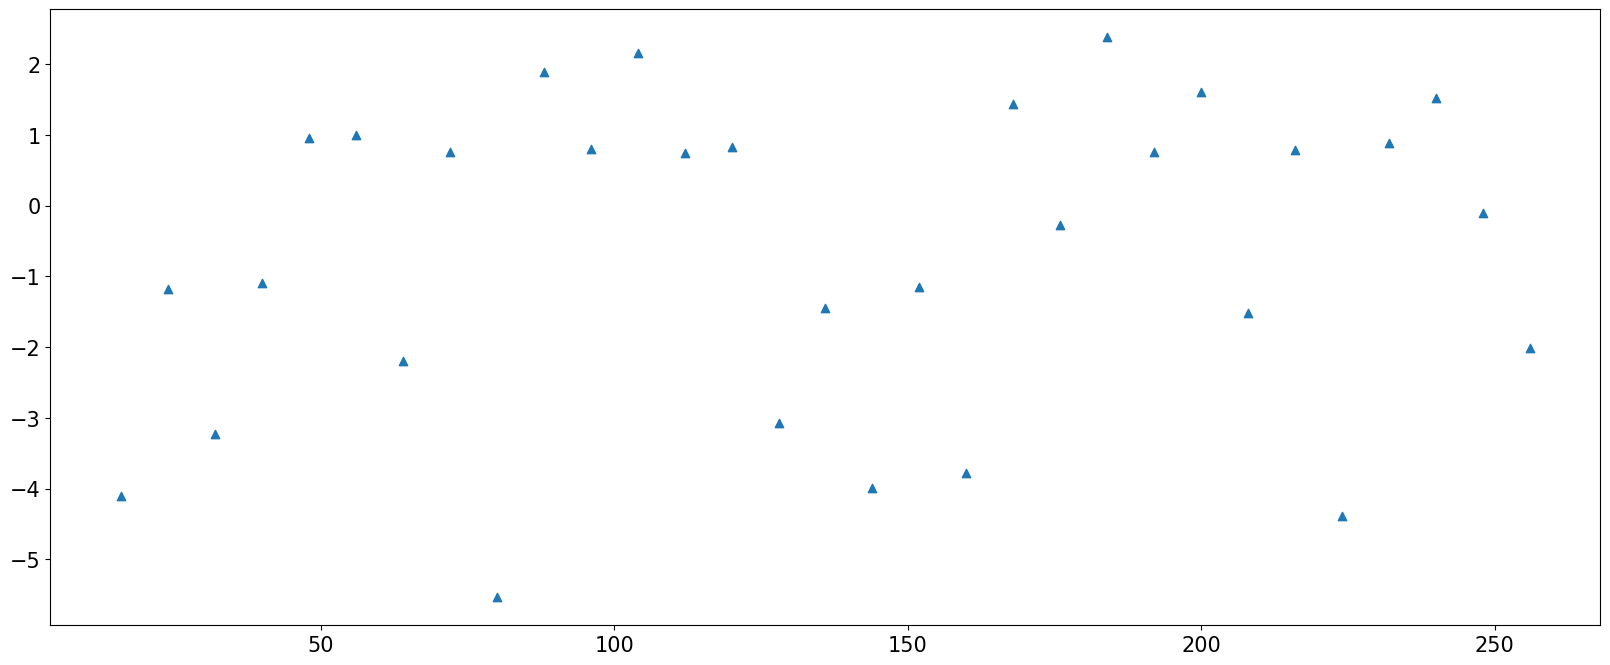

In [39]:
plt.figure(figsize = (20,8))
plt.scatter(GPI_df['neurons'], GPI_df['GPI'], marker='^')

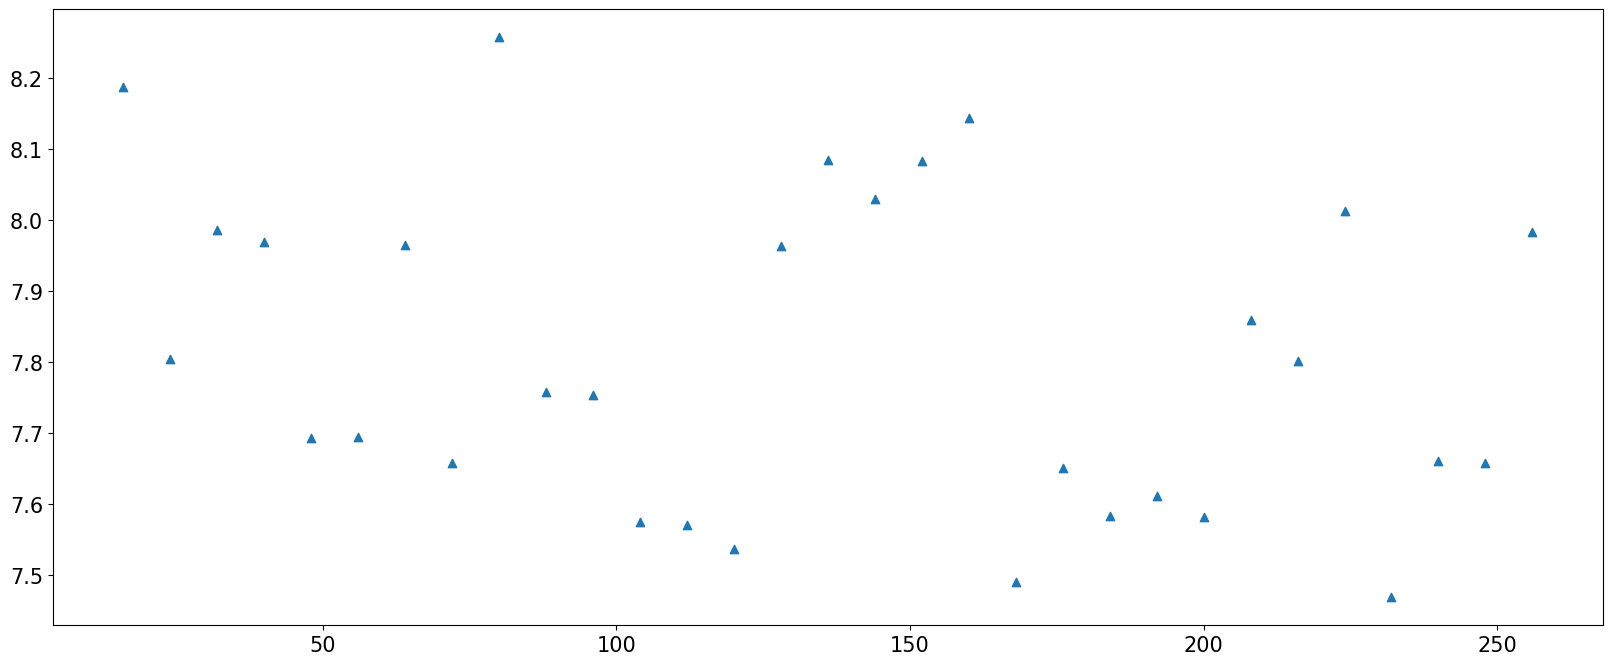

In [40]:
plt.figure(figsize = (20,8))
plt.scatter(hist_model_GRU['neurons'], hist_model_GRU['mape'], marker='^')

In [42]:
%cd G:/Meu Drive 
path_model = os.listdir('model_GRU_Only_coeff') #'model_GRU_Only_coeff' 
path_model[2] 

G:\Meu Drive


'model_GRU_Only_coeff32.h5'

In [44]:
#import os
#%cd G:/Meu Drive 
#path_model = os.listdir('model_GRU_Only_coeff')
@jit
def test_wt_gru_only_coeff():
    results1 = []
    for i, model_name in enumerate(path_model[:31]):
        load_model = tf.keras.models.load_model('G:/Meu Drive/model_GRU_Only_coeff/'+ model_name , compile=False)
        load_model.compile(loss=tf.losses.MeanSquaredError(),
                           metrics=['mae', 'mape', 'msle', 'logcosh', chi_square, mean_bias_error,
                                    keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
        
        SPLIT = path_model[i].split('model_GRU_Only_coeff') #model_GRU_Only_coeff
        neurons = SPLIT[1].split('.')    
        results1.append(load_model.evaluate(teste_x, teste_y, batch_size=256))
        results1[i].insert(0, neurons[0])
    return results1
results1 = test_wt_gru_only_coeff()

219/219 [==============================] - 3s 10ms/step - loss: 0.1185 - mae: 0.2177 - mape: 7.8326 - msle: 0.0064 - logcosh: 0.0507 - chi_square: 9.9898 - mean_bias_error: 0.0025 - root_mean_squared_error: 0.3442 - r_square: 0.9747


In [45]:
hist_model_GRU_Only_coeff = pd.DataFrame(results1, columns=['neurons', 'mse', 'mae', 'mape', 'msle', 'log_cosh',
                                                'chi_2', 'mean_bias_error', 'rmse', 'R_square'])
hist_model_GRU_Only_coeff['neurons'] = hist_model_GRU_Only_coeff['neurons'].astype(int)
hist_model_GRU_Only_coeff = hist_model_GRU_Only_coeff.sort_values(by=['neurons'])
hist_model_GRU_Only_coeff.set_index('neurons')

hist_model_GRU_Only_coeff

neurons       mse       mae      mape      msle  log_cosh      chi_2  \
0        16  0.151409  0.249809  8.716087  0.007835  0.063279  12.518572   
1        24  0.142314  0.242874  8.594615  0.007330  0.060153  11.814890   
2        32  0.129307  0.226251  8.209026  0.006725  0.054721  10.779701   
3        40  0.115173  0.216141  7.904139  0.006338  0.049901   9.700055   
4        48  0.113288  0.215497  7.932120  0.006171  0.049099   9.561869   
5        56  0.112054  0.214451  8.021355  0.006121  0.048469   9.429935   
6        64  0.109410  0.211409  7.795759  0.006004  0.047524   9.213466   
7        72  0.120019  0.220482  7.844255  0.006379  0.051444  10.055000   
8        80  0.114091  0.214243  7.777925  0.006181  0.049121   9.554556   
9        88  0.117243  0.219267  7.942954  0.006239  0.050597   9.823696   
10       96  0.113321  0.215059  7.958063  0.006152  0.049125   9.487593   
11      104  0.118481  0.222685  7.939630  0.006309  0.051262   9.920889   
12      112  0.114334  0.216817  7.801566  0.006162  0.049329   9.633657   
13      120  0.112137  0.213712  7.714644  0.006119  0.048518   9.440962   
14      128  0.112839  0.214903  7.861993  0.006111  0.048811   9.438601   
15      136  0.119436  0.218681  7.967551  0.006299  0.051092   9.977176   
16      144  0.113812  0.213841  7.844697  0.006144  0.048912   9.503523   
17      152  0.114336  0.217705  7.789675  0.006377  0.049627   9.654561   
18      160  0.110726  0.212841  7.869987  0.006082  0.048165   9.348825   
19      168  0.112501  0.214279  7.748598  0.006177  0.048781   9.503190   
20      176  0.111932  0.213104  7.845553  0.006143  0.048491   9.420499   
21      184  0.116474  0.215348  7.920969  0.006262  0.049997   9.794938   
22      192  0.117080  0.219401  7.813966  0.006368  0.050518   9.855062   
23      200  0.115479  0.215470  7.867143  0.006182  0.049740   9.687038   
24      208  0.112145  0.213323  7.685975  0.006142  0.048396   9.436693   
25      216  0.116663  0.217272  7.967068  0.006249  0.050297   9.801701   
26      224  0.115234  0.213490  7.917681  0.006341  0.049475   9.702664   
27      232  0.115782  0.214160  7.653896  0.006202  0.049602   9.752424   
28      240  0.121159  0.222970  7.869018  0.006542  0.052016  10.131459   
29      248  0.118117  0.218776  7.988405  0.006488  0.050922   9.945690   
30      256  0.118477  0.217650  7.832583  0.006406  0.050712   9.989772   

    mean_bias_error      rmse  R_square  
0          0.053713  0.389113  0.967728  
1          0.036715  0.377245  0.969666  
2          0.011372  0.359593  0.972439  
3          0.012146  0.339371  0.975451  
4          0.020135  0.336583  0.975853  
5         -0.014813  0.334745  0.976116  
6          0.032357  0.330772  0.976680  
7          0.029816  0.346437  0.974418  
8          0.018966  0.337774  0.975682  
9          0.013996  0.342408  0.975010  
10         0.005806  0.336631  0.975846  
11        -0.006249  0.344210  0.974746  
12         0.050391  0.338133  0.975630  
13         0.021775  0.334868  0.976098  
14         0.038122  0.335916  0.975949  
15         0.039690  0.345595  0.974543  
16         0.031955  0.337360  0.975741  
17         0.051214  0.338137  0.975630  
18         0.007756  0.332755  0.976399  
19         0.031574  0.335411  0.976021  
20         0.025226  0.334563  0.976142  
21         0.012891  0.341283  0.975174  
22         0.004780  0.342170  0.975045  
23         0.003901  0.339822  0.975386  
24         0.011018  0.334881  0.976097  
25         0.015393  0.341560  0.975134  
26         0.013116  0.339461  0.975438  
27         0.019002  0.340267  0.975322  
28         0.067767  0.348079  0.974175  
29         0.031824  0.343681  0.974824  
30         0.002468  0.344205  0.974747

In [46]:
hist_model_GRU_Only_coeff_Norm = pd.DataFrame(columns=['neurons', 'mse', 'mae', 'mape', 'msle', 'log_cosh',
                                 'chi_2', 'mean_bias_error', 'rmse', 'R_square'])
hist_model_GRU_Only_coeff_Norm = (hist_model_GRU_Only_coeff-hist_model_GRU_Only_coeff.min())/(hist_model_GRU_Only_coeff.max()-hist_model_GRU_Only_coeff.min())
hist_model_GRU_Only_coeff_Norm['neurons'] = hist_model_GRU_Only_coeff['neurons']
hist_model_GRU_Only_coeff_Norm

neurons       mse       mae      mape      msle  log_cosh     chi_2  \
0        16  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1        24  0.783433  0.819392  0.885640  0.724007  0.801585  0.787092   
2        32  0.473742  0.386503  0.522627  0.393830  0.456829  0.473884   
3        40  0.137205  0.123236  0.235591  0.182564  0.150840  0.147224   
4        48  0.092339  0.106450  0.261934  0.091037  0.099989  0.105414   
5        56  0.062951  0.079217  0.345944  0.064078  0.059947  0.065495   
6        64  0.000000  0.000000  0.133557  0.000000  0.000000  0.000000   
7        72  0.252590  0.236259  0.179213  0.204691  0.248833  0.254617   
8        80  0.111455  0.073788  0.116767  0.096545  0.101324  0.103201   
9        88  0.186502  0.204632  0.272133  0.128077  0.195062  0.184633   
10       96  0.093112  0.095052  0.286358  0.080958  0.101606  0.082940   
11      104  0.215968  0.293632  0.269004  0.166633  0.237258  0.214039   
12      112  0.117241  0.140838  0.139023  0.086031  0.114538  0.127134   
13      120  0.064923  0.059964  0.057191  0.062733  0.063098  0.068832   
14      128  0.081649  0.090978  0.195913  0.058726  0.081667  0.068118   
15      136  0.238710  0.189359  0.295290  0.160975  0.226436  0.231070   
16      144  0.104812  0.063335  0.179629  0.076585  0.088066  0.087760   
17      152  0.117296  0.163943  0.127829  0.203494  0.133484  0.133459   
18      160  0.031327  0.037293  0.203439  0.042674  0.040698  0.040955   
19      168  0.073584  0.074734  0.089157  0.094489  0.079758  0.087660   
20      176  0.060057  0.044131  0.180436  0.075901  0.061344  0.062640   
21      184  0.168200  0.102563  0.251435  0.141150  0.156983  0.175932   
22      192  0.182625  0.208129  0.150697  0.198863  0.190041  0.194123   
23      200  0.144500  0.105744  0.200761  0.097275  0.140658  0.143285   
24      208  0.065121  0.049831  0.030200  0.075304  0.055366  0.067540   
25      216  0.172703  0.152663  0.294835  0.133822  0.175971  0.177978   
26      224  0.138667  0.054181  0.248340  0.183771  0.123847  0.148013   
27      232  0.151710  0.071645  0.000000  0.108062  0.131912  0.163068   
28      240  0.279740  0.301067  0.202526  0.293761  0.285083  0.277750   
29      248  0.207305  0.191845  0.314923  0.264494  0.215696  0.221543   
30      256  0.215889  0.162523  0.168225  0.219670  0.202335  0.234881   

    mean_bias_error      rmse  R_square  
0          0.829819  1.000000  0.000000  
1          0.623976  0.796566  0.216566  
2          0.317091  0.494000  0.526260  
3          0.326461  0.147389  0.862794  
4          0.423206  0.099607  0.907657  
5          0.000000  0.068094  0.937046  
6          0.571203  0.000000  1.000000  
7          0.540434  0.268507  0.747407  
8          0.409046  0.120014  0.888541  
9          0.348861  0.199441  0.813496  
10         0.249680  0.100433  0.906885  
11         0.103705  0.230335  0.784027  
12         0.789588  0.126176  0.882755  
13         0.443063  0.070213  0.935076  
14         0.641019  0.088164  0.918350  
15         0.660006  0.254068  0.761289  
16         0.566331  0.112930  0.895186  
17         0.799557  0.126235  0.882702  
18         0.273298  0.033988  0.968673  
19         0.561718  0.079516  0.926413  
20         0.484852  0.064981  0.939943  
21         0.335474  0.180171  0.831800  
22         0.237257  0.195365  0.817371  
23         0.226619  0.155121  0.855496  
24         0.312804  0.070427  0.934876  
25         0.365784  0.184918  0.827292  
26         0.338208  0.148940  0.861329  
27         0.409487  0.162754  0.848286  
28         1.000000  0.296650  0.720261  
29         0.564745  0.221269  0.792696  
30         0.209260  0.230253  0.784107

In [55]:
del GPI_df1
a_j = [1, 1, 1, 1, 1, 1, 1, 1, -1]
GPI1 = np.zeros(31)
GPI_df1 = pd.DataFrame(columns=['neurons', 'GPI'])
for j in range(31):
    for i, df_name in enumerate(list(hist_model_GRU_Only_coeff)[1:]):
        GPI1[j] = GPI1[j] + a_j[i]*(hist_model_GRU_Only_coeff_Norm[df_name].median()-hist_model_GRU_Only_coeff_Norm[df_name][j])
    GPI_df1 = GPI_df1._append({'GPI': GPI1[j]}, ignore_index=True)
GPI_df1['neurons'] =  hist_model_GRU_Only_coeff_Norm['neurons']
print('Better GPI: ', GPI_df1.idxmax()[1]*8+16, 'neurons\n\n', GPI_df1)

Better GPI:  64 neurons

     neurons       GPI
0        16 -7.276291
1        24 -5.451598
2        32 -2.438718
3        40 -0.034188
4        48  0.181208
5        56  0.744848
6        64  0.848767
7        72 -0.884209
8        80  0.309928
9        88 -0.352317
10       96  0.370273
11      104 -0.393020
12      112 -0.204287
13      120  0.598587
14      128  0.165645
15      136 -0.941097
16      144  0.169265
17      152 -0.369068
18      160  0.818529
19      168  0.339326
20      176  0.459128
21      184 -0.126582
22      192 -0.186203
23      200  0.195060
24      208  0.761811
25      216 -0.277854
26      224  0.030890
27      232  0.203174
28      240 -1.662788
29      248 -0.855597
30      256 -0.305401


In [56]:
df_name

'R_square'

In [143]:
hist_model_GRU_Only_coeff[4:5]

neurons      mse       mae      mape      msle  log_cosh     chi_2  \
4        4  0.10294  0.207368  7.009522  0.005276  0.045092  8.397458   

   mean_bias_error      rmse  R_square  
4         0.010952  0.320842  0.978719

-1.0

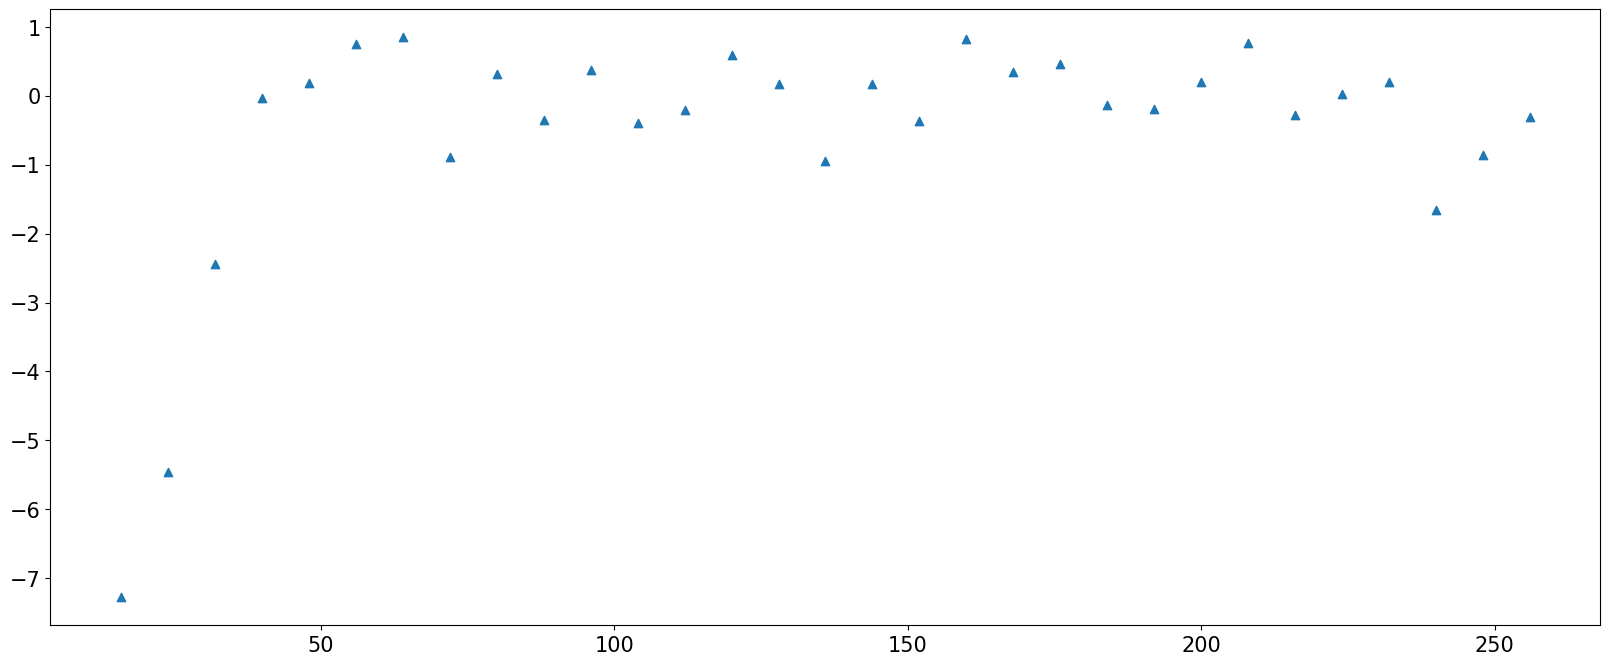

In [57]:
plt.figure(figsize = (20,8))
plt.scatter(GPI_df1['neurons'], GPI_df1['GPI'], marker='^')

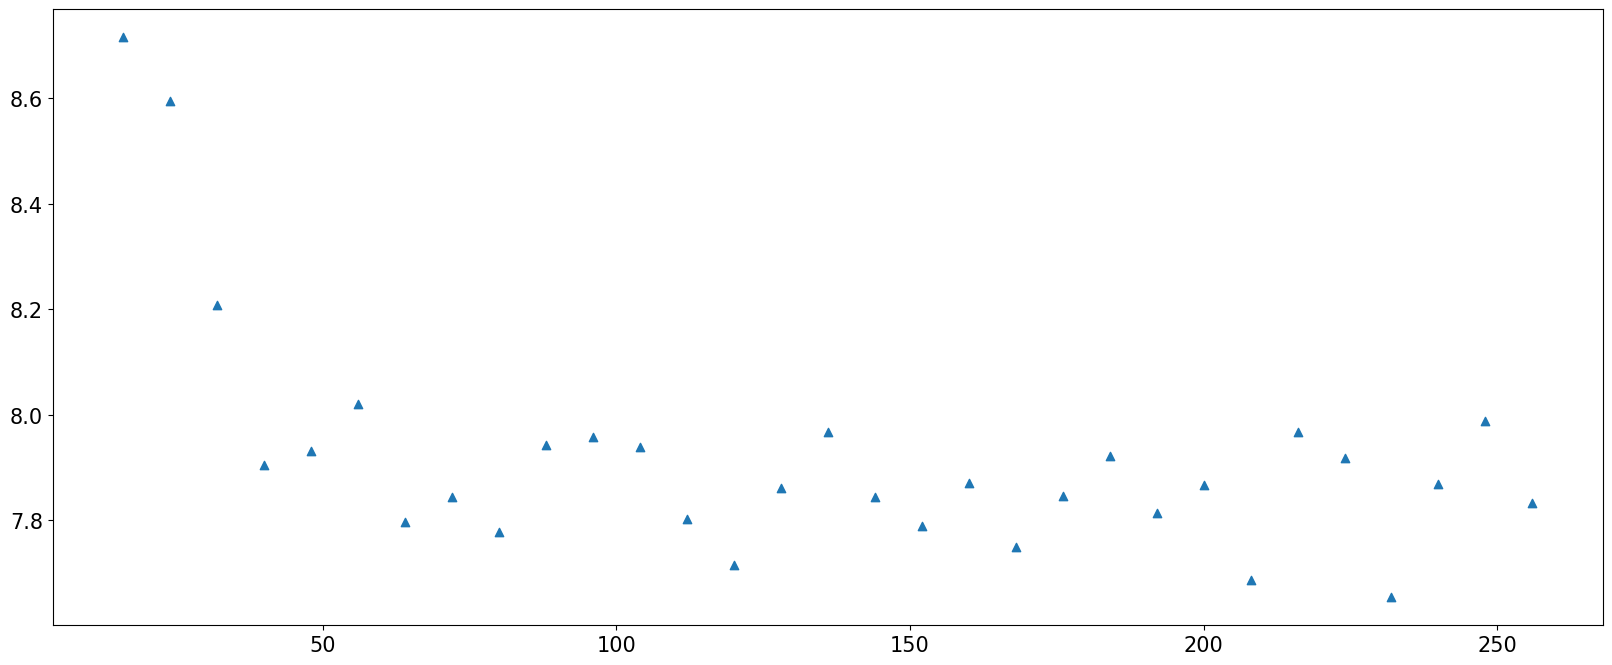

In [58]:
#hist_model_GRU_Only_coeff = pd.DataFrame(columns=['neurons', 'mse', 'mae', 'mape', 'msle', 'log_cosh',
#                                 'cos_similarity', 'mean_bias_error', 'rmse', 'R_square'])
#hist_model_GRU_Only_coeff['neurons'] = hist_model_GRU_Only_coeff['neurons'].astype(int)
#hist_model_GRU_Only_coeff = hist_model_GRU_Only_coeff.sort_values(by=['neurons'])
#hist_model_GRU_Only_coeff.set_index('neurons')
plt.figure(figsize = (20,8))
plt.scatter(hist_model_GRU_Only_coeff['neurons'], hist_model_GRU_Only_coeff['mape'], marker='^')

In [35]:
SPLIT = path_model[0].split('model_GRU_with_coeff_original')
SPLIT[1].split('.')

['16', 'h5']

In [59]:
%cd G:/Meu Drive 
path_model = os.listdir('model_GRU_with_coeff_original') #model_GRU_with_coeff_original
path_model

G:\Meu Drive


['model_GRU_with_coeff_original16.h5',
 'model_GRU_with_coeff_original24.h5',
 'model_GRU_with_coeff_original32.h5',
 'model_GRU_with_coeff_original40.h5',
 'model_GRU_with_coeff_original48.h5',
 'model_GRU_with_coeff_original56.h5',
 'model_GRU_with_coeff_original64.h5',
 'model_GRU_with_coeff_original72.h5',
 'model_GRU_with_coeff_original80.h5',
 'model_GRU_with_coeff_original88.h5',
 'model_GRU_with_coeff_original96.h5',
 'model_GRU_with_coeff_original104.h5',
 'model_GRU_with_coeff_original112.h5',
 'model_GRU_with_coeff_original120.h5',
 'model_GRU_with_coeff_original128.h5',
 'model_GRU_with_coeff_original136.h5',
 'model_GRU_with_coeff_original144.h5',
 'model_GRU_with_coeff_original152.h5',
 'model_GRU_with_coeff_original160.h5',
 'model_GRU_with_coeff_original168.h5',
 'model_GRU_with_coeff_original176.h5',
 'model_GRU_with_coeff_original184.h5',
 'model_GRU_with_coeff_original192.h5',
 'model_GRU_with_coeff_original200.h5',
 'model_GRU_with_coeff_original208.h5',
 'model_GRU

In [61]:
#import os
#%cd G:/Meu Drive 
#path_model = os.listdir('model_GRU_with_coeff_original')
@jit
def test_model_GRU_with_coeff_original():
    results2 = []
    for i, model_name in enumerate(path_model[:31]):
        load_model = tf.keras.models.load_model('G:/Meu Drive/model_GRU_with_coeff_original/'+ model_name , compile=False) #model_GRU_with_coeff_original
        load_model.compile(loss=tf.losses.MeanSquaredError(),
                           metrics=['mae', 'mape', 'msle', 'logcosh', chi_square, mean_bias_error,
                                        keras.metrics.RootMeanSquaredError(), tfa.metrics.r_square.RSquare()])
    
        SPLIT = path_model[i].split('model_GRU_with_coeff_original')#model_GRU_with_coeff_original
        neurons = SPLIT[1].split('.')    
        results2.append(load_model.evaluate(teste_x_with_original, teste_y, batch_size=256))
        results2[i].insert(0, neurons[0])
    return results2
results2 = test_model_GRU_with_coeff_original()

219/219 [==============================] - 3s 10ms/step - loss: 0.1139 - mae: 0.2134 - mape: 7.7035 - msle: 0.0062 - logcosh: 0.0492 - chi_square: 9.6257 - mean_bias_error: 0.0238 - root_mean_squared_error: 0.3375 - r_square: 0.9757


In [70]:
hist_model_GRU_with_coeff_original = pd.DataFrame(results2 , columns=['neurons', 'mse', 'mae', 'mape', 'msle', 'log_cosh',
                                 'chi_2', 'mean_bias_error', 'rmse', 'R_square'])
hist_model_GRU_with_coeff_original['neurons'] = hist_model_GRU_with_coeff_original['neurons'].astype(int)
hist_model_GRU_with_coeff_original = hist_model_GRU_with_coeff_original.sort_values(by=['neurons'])
hist_model_GRU_with_coeff_original.set_index('neurons')
#hist_model_GRU_with_coeff_original.index.rename('Model', inplace=True)

mse       mae      mape      msle  log_cosh      chi_2  \
neurons                                                                
16       0.151049  0.242821  8.706865  0.007539  0.062761  12.447741   
24       0.146423  0.239360  8.435456  0.007501  0.060893  12.083598   
32       0.136076  0.231133  8.309127  0.007019  0.057110  11.301276   
40       0.150136  0.241047  8.512428  0.007552  0.062180  12.361009   
48       0.114655  0.212886  7.844725  0.006308  0.049262   9.621006   
56       0.111577  0.212092  7.762897  0.006316  0.048308   9.416081   
64       0.116098  0.213808  8.045930  0.006484  0.049882   9.795422   
72       0.109428  0.209843  7.818146  0.006134  0.047541   9.235312   
80       0.114680  0.213367  7.684212  0.006267  0.049346   9.629982   
88       0.118990  0.215901  7.972784  0.006380  0.050793   9.912181   
96       0.114598  0.213451  7.856315  0.006237  0.049317   9.629376   
104      0.109595  0.208054  7.635998  0.006043  0.047331   9.222593   
112      0.109711  0.210600  7.709141  0.006127  0.047515   9.292109   
120      0.114367  0.213901  7.752319  0.006386  0.049307   9.671516   
128      0.118429  0.219270  7.968744  0.006428  0.050931   9.939259   
136      0.111885  0.214367  7.699444  0.006177  0.048435   9.449555   
144      0.111447  0.209884  7.567982  0.006126  0.047837   9.425621   
152      0.110053  0.211548  7.754966  0.006190  0.047753   9.285426   
160      0.105763  0.206202  7.498819  0.006043  0.046056   8.915790   
168      0.107002  0.203995  7.568493  0.005934  0.046100   9.037045   
176      0.108337  0.207881  7.712798  0.006213  0.046967   9.194900   
184      0.112752  0.211926  7.706536  0.006165  0.048438   9.496586   
192      0.106201  0.207328  7.611889  0.006032  0.046176   8.992755   
200      0.111639  0.211669  7.750243  0.006124  0.048304   9.423602   
208      0.110646  0.208782  7.661747  0.006094  0.047553   9.347436   
216      0.112293  0.211183  7.542060  0.006214  0.048355   9.444153   
224      0.108939  0.207057  7.662483  0.005979  0.047018   9.176968   
232      0.109767  0.206979  7.587622  0.006002  0.047464   9.310253   
240      0.112019  0.210752  7.632554  0.006114  0.048342   9.449812   
248      0.112724  0.210177  7.751749  0.006030  0.048343   9.491824   
256      0.113905  0.213449  7.703500  0.006224  0.049163   9.625669   

         mean_bias_error      rmse  R_square  
neurons                                       
16              0.027067  0.388650  0.967805  
24              0.034350  0.382653  0.968790  
32              0.045639  0.368885  0.970996  
40              0.027834  0.387474  0.967999  
48              0.036663  0.338608  0.975562  
56              0.040432  0.334032  0.976218  
64              0.005176  0.340732  0.975254  
72              0.020693  0.330800  0.976676  
80              0.016423  0.338644  0.975556  
88              0.019109  0.344950  0.974638  
96             -0.003973  0.338524  0.975574  
104             0.020145  0.331051  0.976640  
112             0.033581  0.331226  0.976616  
120             0.012970  0.338182  0.975623  
128             0.033364  0.344135  0.974757  
136             0.057975  0.334493  0.976152  
144             0.037551  0.333837  0.976246  
152             0.041188  0.331743  0.976543  
160             0.020339  0.325213  0.977457  
168             0.011413  0.327111  0.977193  
176             0.006649  0.329145  0.976908  
184             0.047365  0.335786  0.975967  
192             0.022474  0.325885  0.977364  
200             0.022441  0.334124  0.976205  
208            -0.003334  0.332635  0.976416  
216             0.024015  0.335101  0.976065  
224             0.006011  0.330059  0.976780  
232             0.006747  0.331311  0.976604  
240             0.026873  0.334693  0.976124  
248             0.029510  0.335744  0.975973  
256             0.023804  0.337498  0.975722

In [71]:
hist_model_GRU_with_coeff_original_Norm = pd.DataFrame(columns=['neurons', 'mse', 'mae', 'mape', 'msle', 'log_cosh',
                                 'chi_2', 'mean_bias_error', 'rmse', 'R_square'])
hist_model_GRU_with_coeff_original_Norm = (hist_model_GRU_with_coeff_original-hist_model_GRU_with_coeff_original.min())/(hist_model_GRU_with_coeff_original.max()-hist_model_GRU_with_coeff_original.min())
hist_model_GRU_with_coeff_original_Norm['neurons'] = hist_model_GRU_with_coeff_original['neurons']
hist_model_GRU_with_coeff_original_Norm

neurons       mse       mae      mape      msle  log_cosh     chi_2  \
0        16  1.000000  1.000000  1.000000  0.991953  1.000000  1.000000   
1        24  0.897866  0.910879  0.775332  0.968551  0.888177  0.896900   
2        32  0.669381  0.698979  0.670759  0.670692  0.661670  0.675402   
3        40  0.979849  0.954314  0.839048  1.000000  0.965175  0.975444   
4        48  0.196352  0.229000  0.286335  0.231268  0.191892  0.199668   
5        56  0.128386  0.208542  0.218600  0.236113  0.134772  0.141647   
6        64  0.228214  0.252740  0.452889  0.340183  0.229039  0.249050   
7        72  0.080932  0.150637  0.264333  0.123769  0.088865  0.090466   
8        80  0.196897  0.241384  0.153465  0.205747  0.196919  0.202209   
9        88  0.292080  0.306643  0.392340  0.275724  0.283556  0.282108   
10       96  0.195097  0.243549  0.295929  0.186890  0.195173  0.202038   
11      104  0.084601  0.104551  0.113554  0.067049  0.076293  0.086865   
12      112  0.087171  0.170115  0.174101  0.119490  0.087298  0.106547   
13      120  0.189993  0.255148  0.209843  0.279402  0.194606  0.213969   
14      128  0.279684  0.393415  0.388996  0.305103  0.291789  0.289774   
15      136  0.135185  0.267142  0.166074  0.150370  0.142380  0.151125   
16      144  0.125503  0.151690  0.057252  0.118550  0.106621  0.144348   
17      152  0.094734  0.194541  0.212034  0.158423  0.101592  0.104655   
18      160  0.000000  0.056839  0.000000  0.067371  0.000000  0.000000   
19      168  0.027347  0.000000  0.057675  0.000000  0.002634  0.034331   
20      176  0.056821  0.100091  0.177128  0.172190  0.054491  0.079024   
21      184  0.154326  0.204281  0.171945  0.142590  0.142545  0.164441   
22      192  0.009659  0.085853  0.093598  0.060744  0.007139  0.021791   
23      200  0.129749  0.197647  0.208124  0.117487  0.134535  0.143777   
24      208  0.107816  0.123308  0.134869  0.098953  0.089588  0.122212   
25      216  0.144188  0.185149  0.035795  0.173121  0.137616  0.149595   
26      224  0.070121  0.078881  0.135479  0.027820  0.057584  0.073947   
27      232  0.088405  0.076865  0.073509  0.042113  0.084284  0.111684   
28      240  0.138145  0.174039  0.110704  0.111424  0.136810  0.151198   
29      248  0.153710  0.159226  0.209371  0.059021  0.136874  0.163092   
30      256  0.179783  0.243495  0.169431  0.179441  0.185974  0.200988   

    mean_bias_error      rmse  R_square  
0          0.501062  1.000000  0.000000  
1          0.618628  0.905472  0.102137  
2          0.800867  0.688442  0.330616  
3          0.513446  0.981465  0.020149  
4          0.655963  0.211154  0.803649  
5          0.716800  0.139023  0.871613  
6          0.147691  0.244636  0.771786  
7          0.398165  0.088069  0.919069  
8          0.329247  0.211728  0.803100  
9          0.372602  0.311126  0.707923  
10         0.000000  0.209831  0.804903  
11         0.389331  0.092026  0.915401  
12         0.606213  0.094796  0.912832  
13         0.273509  0.204447  0.810004  
14         0.602712  0.298285  0.720316  
15         1.000000  0.146283  0.864814  
16         0.670298  0.135941  0.874497  
17         0.729006  0.102940  0.905267  
18         0.392456  0.000000  1.000000  
19         0.248369  0.029927  0.972650  
20         0.171471  0.061988  0.943176  
21         0.828726  0.166668  0.845671  
22         0.426921  0.010591  0.990342  
23         0.426387  0.140480  0.870248  
24         0.010321  0.116996  0.892182  
25         0.451797  0.155881  0.855811  
26         0.161172  0.076391  0.929881  
27         0.173048  0.096126  0.911597  
28         0.497934  0.149440  0.861856  
29         0.540493  0.166013  0.846289  
30         0.448392  0.193660  0.820217

In [72]:
a_j = [1, 1, 1, 1, 1, 1, 1, 1, -1]
GPI2 = np.zeros(31)
GPI_df2 = pd.DataFrame(columns=['neurons', 'GPI'])
for j in range(31):
    for i, df_name in enumerate(list(hist_model_GRU_with_coeff_original)[1:]):
        GPI2[j] = GPI2[j] + a_j[i]*(hist_model_GRU_with_coeff_original_Norm[df_name].median()-hist_model_GRU_with_coeff_original_Norm[df_name][j])
    GPI_df2 = GPI_df2._append({'GPI': GPI2[j]}, ignore_index=True)
GPI_df2['neurons'] =  hist_model_GRU_with_coeff_original_Norm['neurons']
print('Better GPI: ', GPI_df2.idxmax()[1]*8+16, 'neurons\n\n', GPI_df2)

Better GPI:  168 neurons

     neurons       GPI
0        16 -6.797696
1        24 -6.064350
2        32 -4.510257
3        40 -6.493272
4        48 -0.702662
5        56 -0.356951
6        64 -0.677335
7        72  0.329151
8        80 -0.239178
9        88 -1.112937
10       96 -0.028283
11      104  0.596448
12      112  0.162419
13      120 -0.315593
14      128 -1.434123
15      136 -0.598426
16      144  0.059613
17      152 -0.097339
18      160  1.178654
19      168  1.267687
20      176  0.765292
21      184 -0.434529
22      192  0.969366
23      200  0.067381
24      208  0.783438
25      216  0.117988
26      224  0.943806
27      232  0.860882
28      240  0.087483
29      248 -0.046193
30      256 -0.285628


In [175]:
hist_model_GRU_with_coeff_original[1:2]

neurons       mse       mae      mape      msle  log_cosh     chi_2  \
1        1  0.105476  0.205055  7.654801  0.005936  0.045884  8.925545   

   mean_bias_error      rmse  R_square  
1         0.014671  0.324771  0.977518

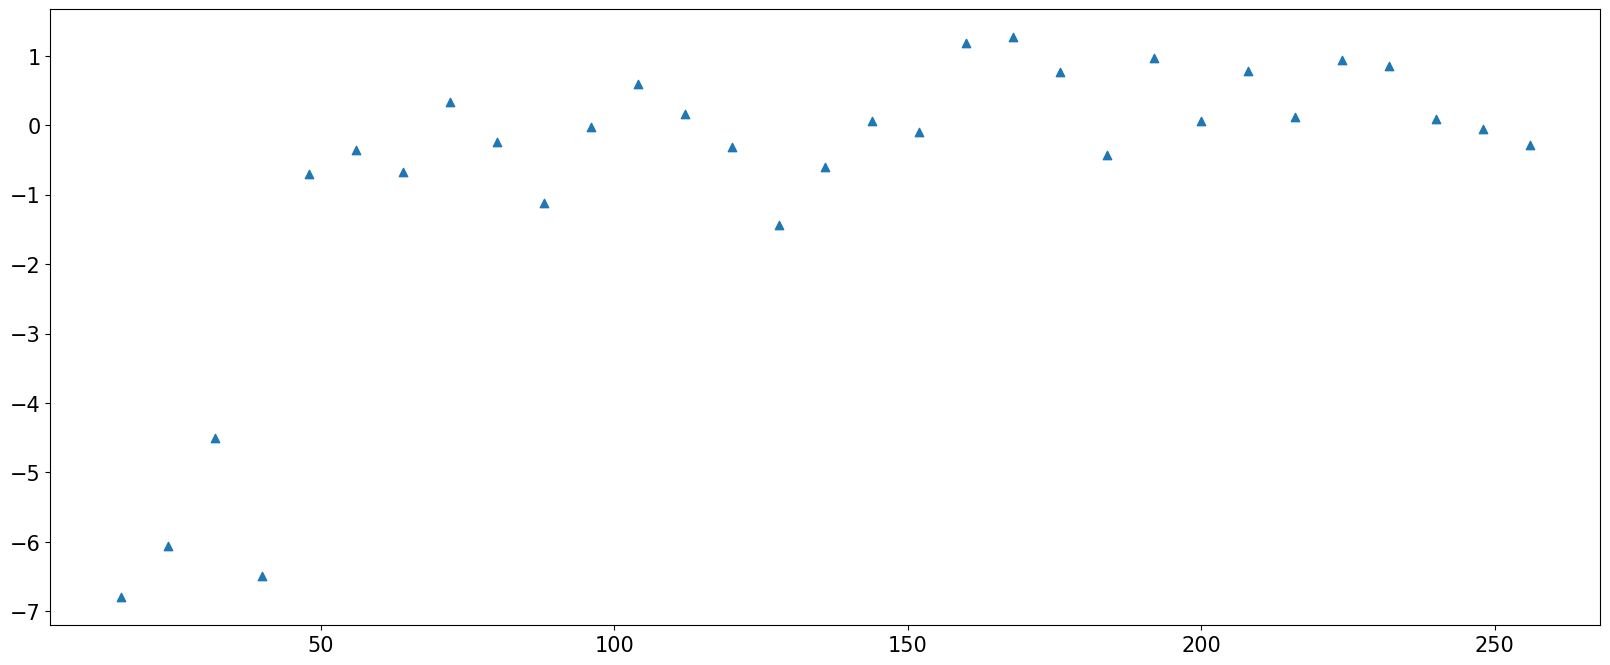

In [73]:
plt.figure(figsize = (20,8))
plt.scatter(hist_model_GRU_with_coeff_original['neurons'], GPI_df2['GPI'], marker='^')

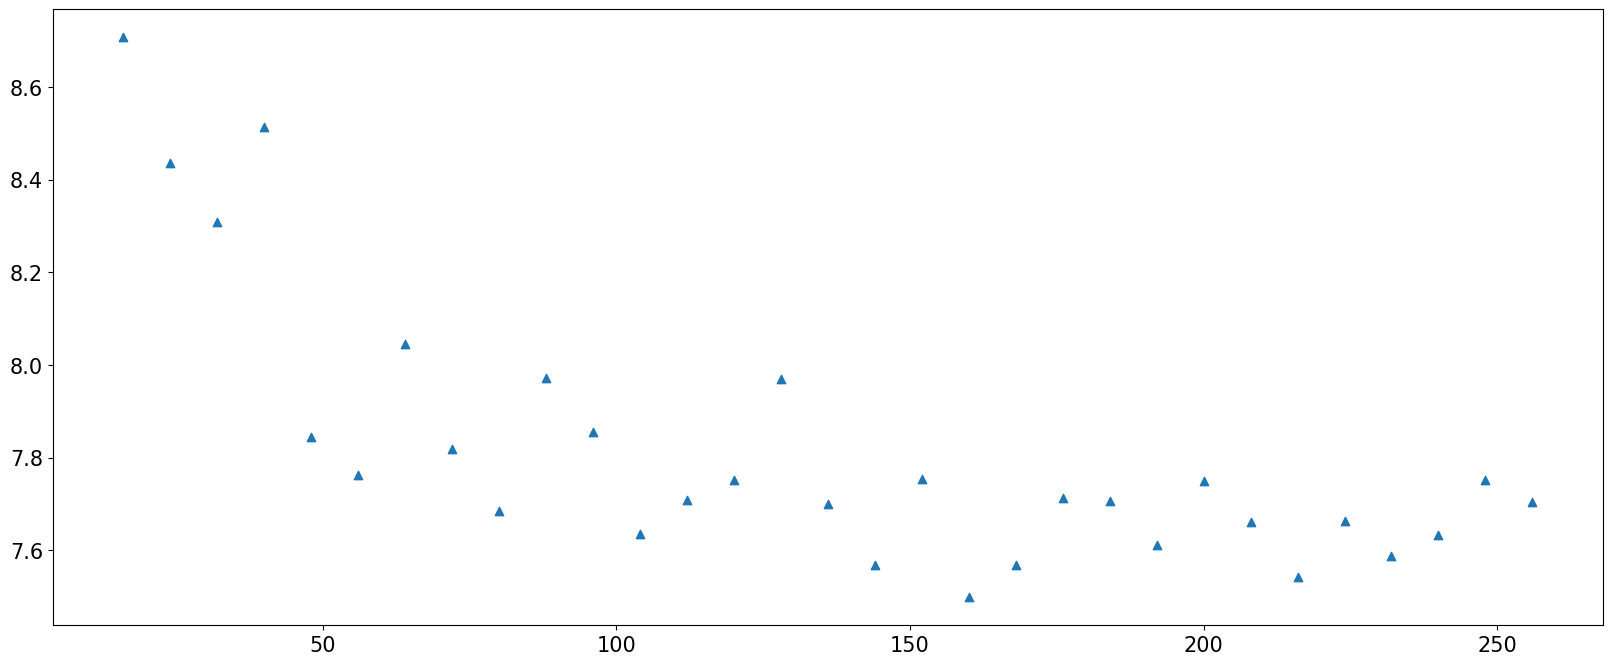

In [74]:
plt.figure(figsize = (20,8))
plt.scatter(hist_model_GRU_with_coeff_original['neurons'], hist_model_GRU_with_coeff_original['mape'], marker='^')

NameError: name 'model_GRU_simple_predict_y' is not defined

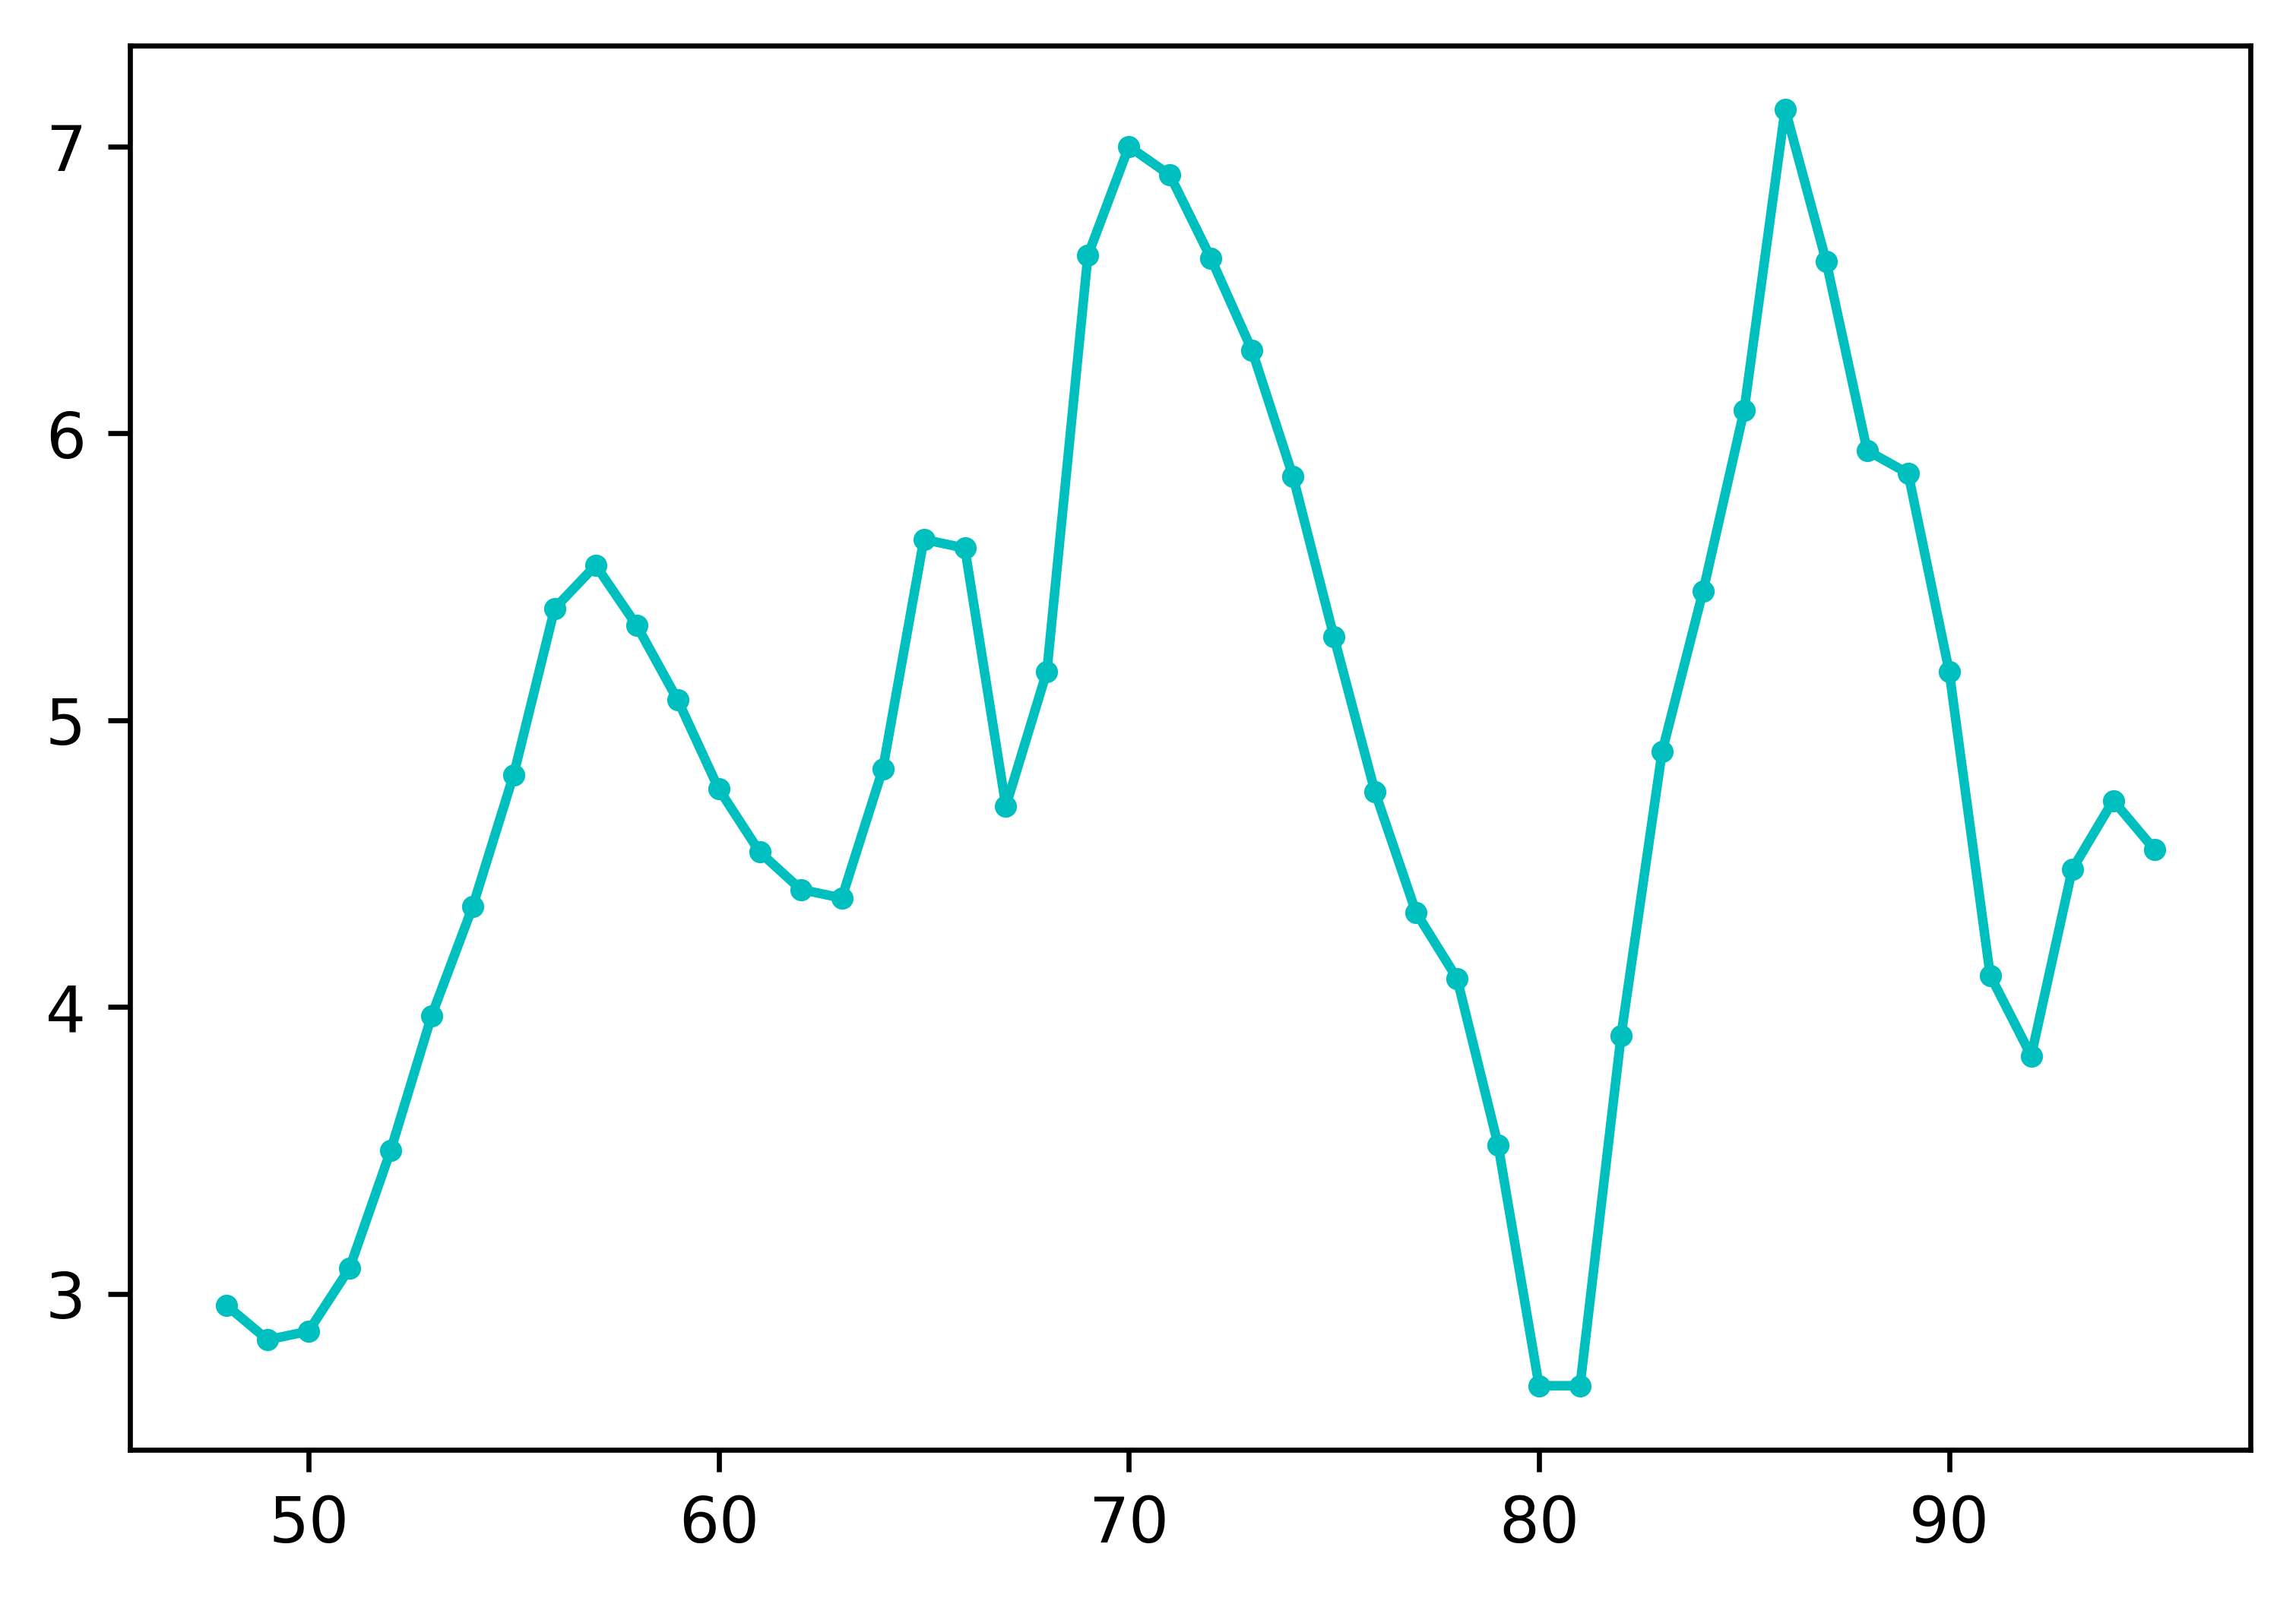

In [259]:
#plot_result(teste_y.reshape(len(teste_y))[96:130], model_GRU_simple_predict_y.reshape(len(teste_y))[96:130])
plt.figure(figsize=(6, 4), dpi=600)
plt.plot(range(48,96), teste_y.reshape(len(teste_y))[48:96], color='c', marker='.', markersize=5)
plt.scatter(range(48,96), model_GRU_simple_predict_y.reshape(len(teste_y))[48:96], marker='+', linewidths=8)
plt.scatter(range(48,96), predict_y.reshape(len(teste_y))[48:96], marker='^', linewidths=2)
plt.scatter(range(48,96), model_WTGRU_WT_original_predict_y.reshape(len(teste_y))[48:96], marker='*', linewidths=3)
plt.scatter(range(48,96), predict_y_model_SWT_all_signal.reshape(len(teste_y)-1)[48:96], color='m', marker='o', linewidths=2)
plt.legend(['Actual', 'GRU', 'SWT-RNN(I)', 'SWT-RNN(II)', 'SWT-RNN(III)'], fontsize=16)
plt.xlabel('Time [Hour]', fontsize=16)
plt.ylabel('Wind Speed [m/s]', fontsize=16)
#plt.title ('Actual and Predicted Values')

plt.minorticks_on()
plt.grid(True, which='major')
plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=1.5)
#plt.rcParams.update({'font.size': 10})

In [2]:
plt.style.use('default')
plt.figure(figsize = (6,4), dpi=1000)
plt.grid(True, which='major', color='#EEEEEE', linestyle='dotted', linewidth=0.25, zorder=-100)
#plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.scatter(hist_model_GRU['neurons'], hist_model_GRU['mape'], marker='+', linewidths=1, s=30, c='red', label="GRU", zorder=10)
plt.scatter(hist_model_GRU_Only_coeff['neurons'], hist_model_GRU_Only_coeff['mape'], marker='*', linewidths=1, 
            s=20, c='orange', label='SWT-RNN(I)', zorder=7)
plt.scatter(hist_model_GRU_with_coeff_original['neurons'], hist_model_GRU_with_coeff_original['mape'],
            marker='^', linewidths=1, s=20, c='b', label='SWT-RNN(II)', zorder=5)
#plt.legend(['GRU', 'SWT-RNN(I)', 'SWT-RNN(II)'], fontsize=16)
plt.ylabel('MAPE [%]', fontsize=10)
plt.xlabel('Cells in Layers GRU and Dense', fontsize=10)
#plt.minorticks_on()

plt.xticks(fontsize=7.5, rotation=45)
plt.yticks(fontsize=7.5)
plt.xticks(np.arange(8, 264, 8));
plt.yticks(np.arange(7.3, 9.05, 0.05));

plt.xlim(8,264)
plt.ylim(7.3,9.05);
plt.legend(bbox_to_anchor=(.994, 0.99),
           loc='upper right', ncols=1,  borderaxespad=0., fontsize=7.5, frameon=True, framealpha=0.4, edgecolor='0.85')
#path_fig ='D:/Users/Dario/OneDrive/DARIO Computador/UnB/Doutorado/Projeto eolica/Wavelet-GRU-RNN/figuras/'
path_fig ='C:/Users/choco/OneDrive/DARIO Computador/UnB/Doutorado/Projeto eolica/Wavelet-GRU-RNN/figuras/'
#plt.savefig(path_fig+'New_figure_11.pdf', dpi=1000, format='pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

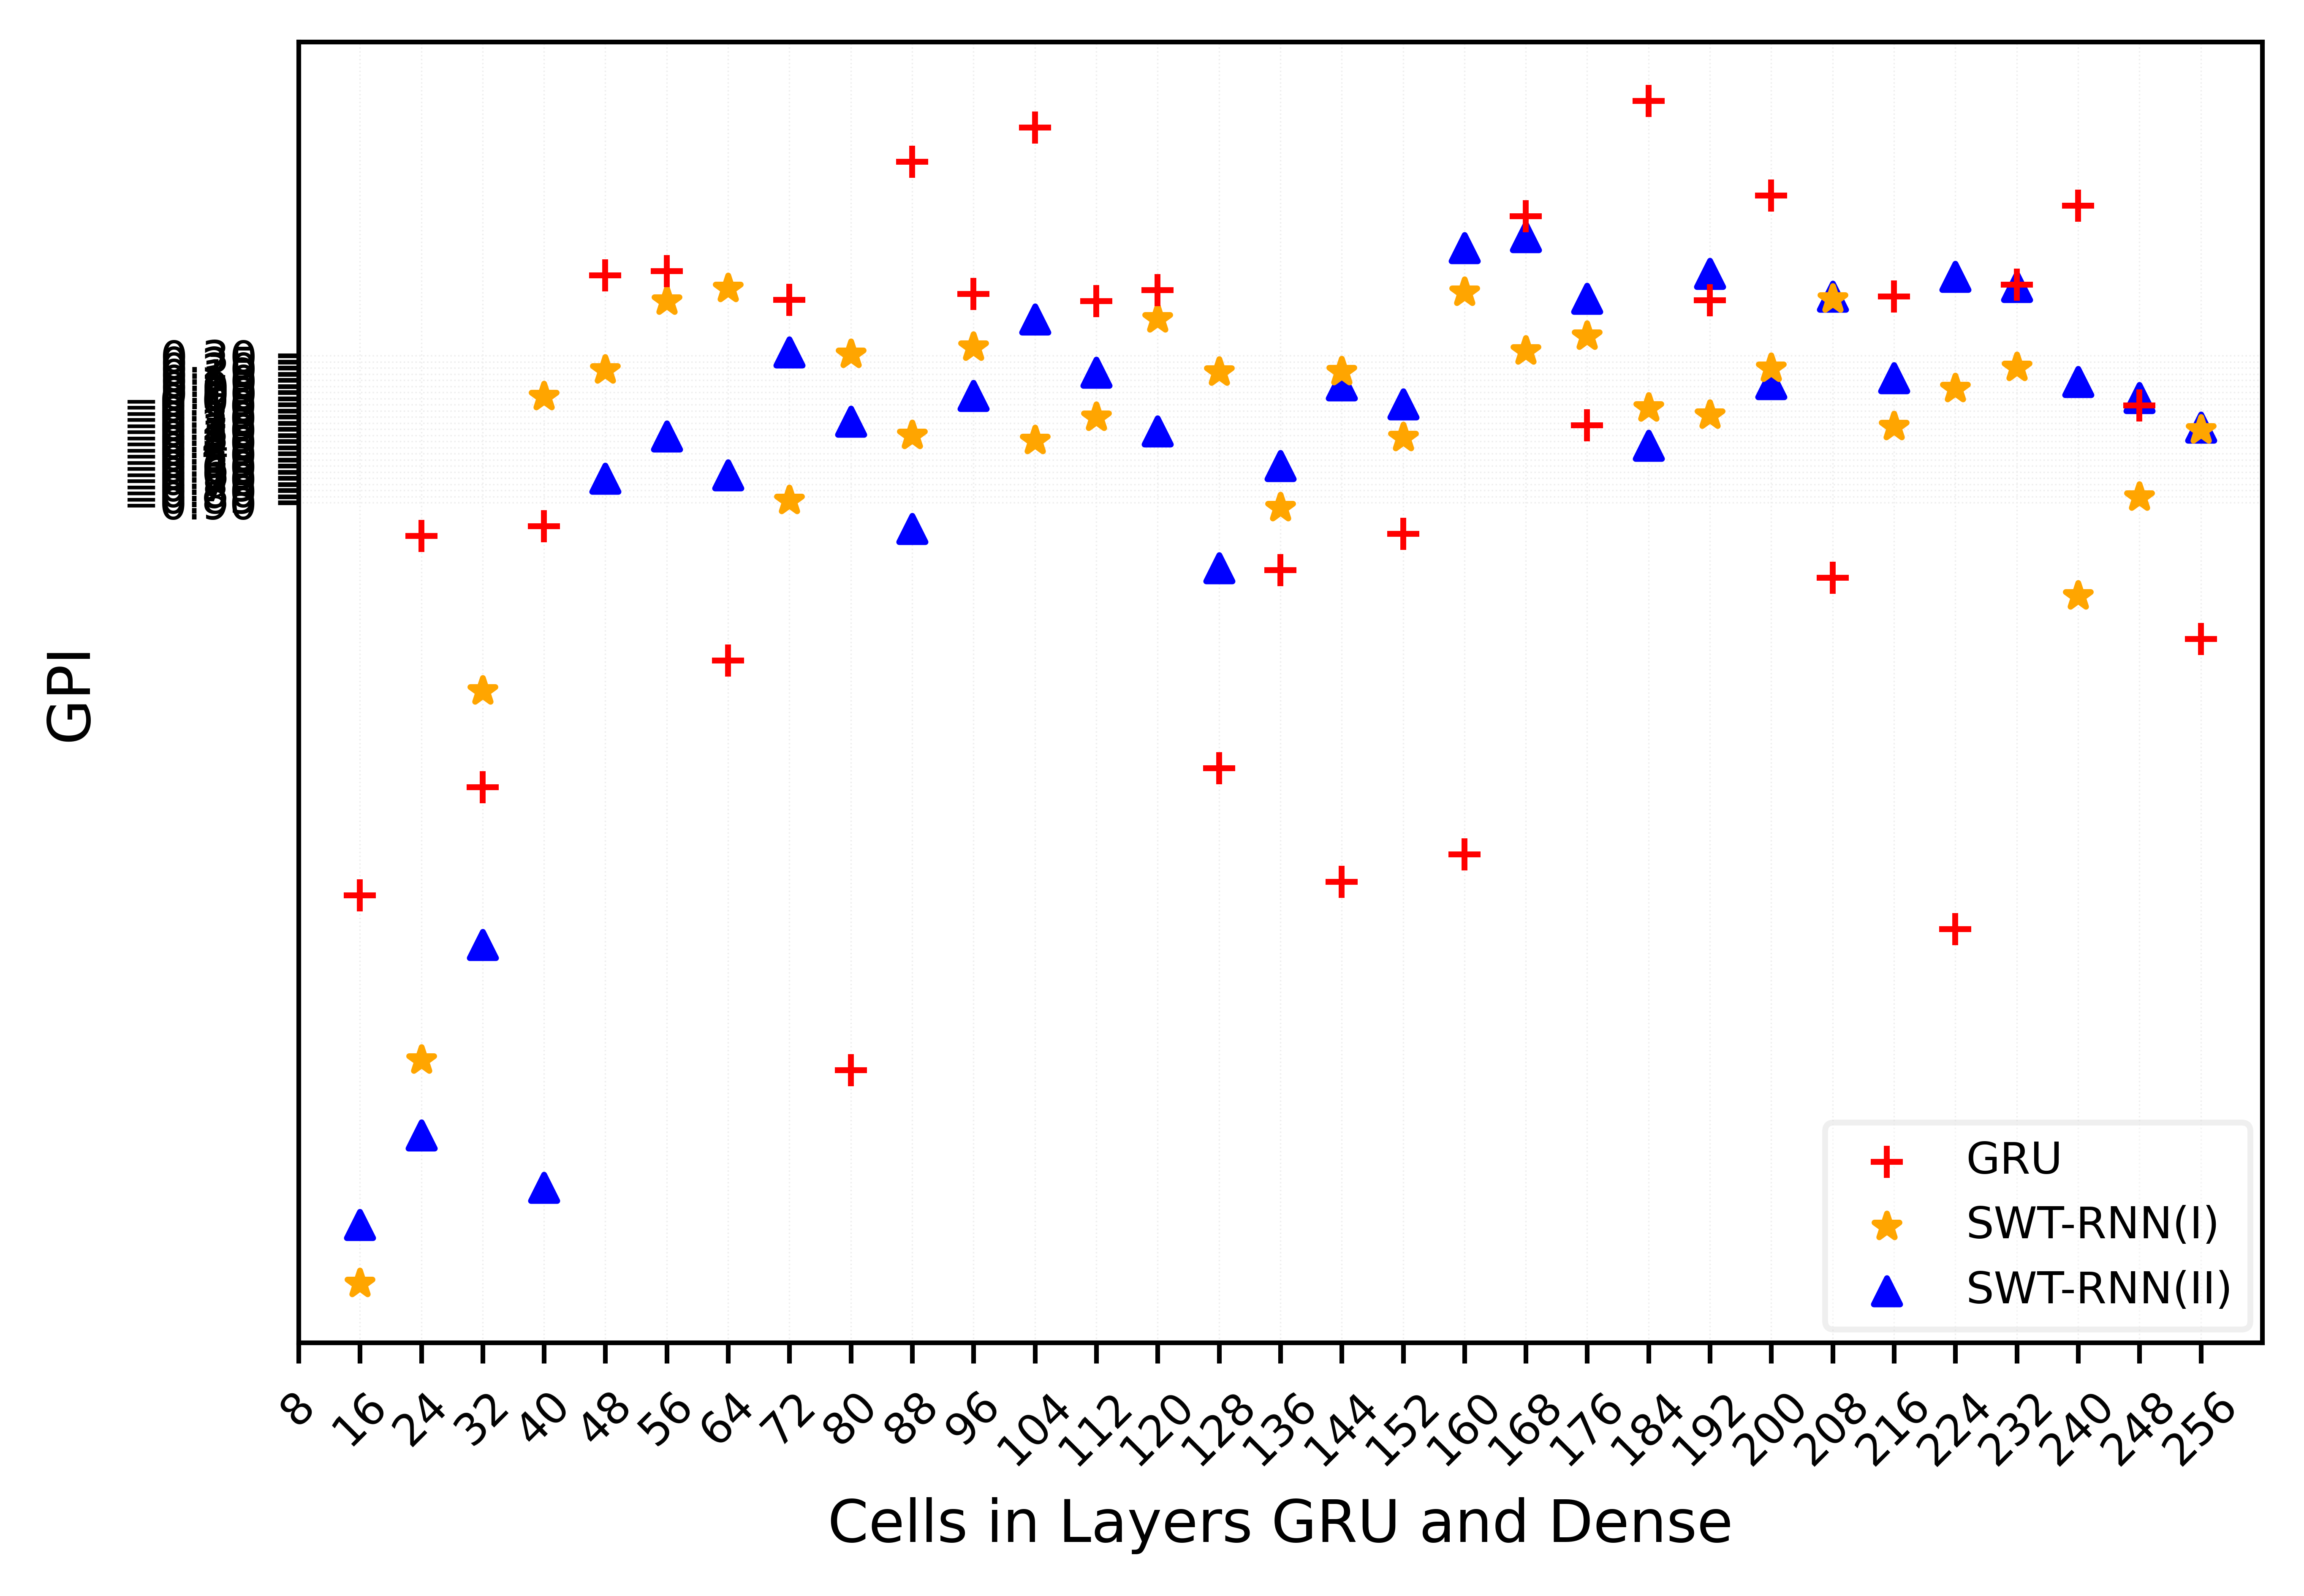

In [78]:
plt.style.use('default')
plt.figure(figsize = (6,4), dpi=1000)
plt.grid(True, which='major', color='#EEEEEE', linestyle='dotted', linewidth=0.25)
#plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.scatter(GPI_df['neurons'], GPI_df['GPI'], marker='+', linewidths=1, s=30, c='red', label='GRU', zorder=10)
plt.scatter(GPI_df1['neurons'], GPI_df1['GPI'], marker='*', linewidths=1, s=20, c='orange', label='SWT-RNN(I)', zorder=7)
plt.scatter(GPI_df2['neurons'], GPI_df2['GPI'], marker='^', linewidths=1, s=20, c='b', label='SWT-RNN(II)', zorder=5)
#plt.legend(['GRU', 'SWT-RNN(I)', 'SWT-RNN(II)'], fontsize=16)
plt.ylabel('GPI', fontsize=10)
plt.xlabel('Cells in Layers GRU and Dense', fontsize=10)
#plt.minorticks_on()

plt.xticks(fontsize=7.5, rotation=45)
plt.yticks(fontsize=7.5)
plt.xticks(np.arange(8, 264, 8));
plt.yticks(np.arange(-0.9, 0.35, 0.05));
#
plt.xlim(8,264)
#plt.ylim(-0.9, 0.3);
plt.legend(bbox_to_anchor=(.994, 0.01),
           loc='lower right', ncols=1,  borderaxespad=0., fontsize=7.5, frameon=True, framealpha=0.4, edgecolor='0.85')
#path_fig ='D:/Users/Dario/OneDrive/DARIO Computador/UnB/Doutorado/Projeto eolica/Wavelet-GRU-RNN/figuras/'
path_fig ='C:/Users/choco/OneDrive/DARIO Computador/UnB/Doutorado/Projeto eolica/Wavelet-GRU-RNN/figuras/'
plt.savefig(path_fig+'New_figure_GPI.pdf', dpi=1000, format='pdf', bbox_inches='tight')

# Concateno as três tabelas e calculo o GPI 

In [79]:
hist_model_GRU_Only_coeff.index = [31+i for i in range(31)]
hist_model_GRU_with_coeff_original.index = [62+i for i in range(31)]
All_models = pd.concat([hist_model_GRU, hist_model_GRU_Only_coeff, hist_model_GRU_with_coeff_original], axis=0)
All_models

neurons       mse       mae      mape      msle  log_cosh      chi_2  \
0        16  0.130874  0.222459  8.186616  0.006925  0.054872  10.832934   
1        24  0.117212  0.212075  7.804163  0.006398  0.050006   9.819254   
2        32  0.125017  0.219418  7.986108  0.006807  0.052863  10.444009   
3        40  0.117599  0.213000  7.968917  0.006587  0.050166   9.827441   
4        48  0.107422  0.205267  7.692644  0.006117  0.046373   9.032893   
..      ...       ...       ...       ...       ...       ...        ...   
88      224  0.108939  0.207057  7.662483  0.005979  0.047018   9.176968   
89      232  0.109767  0.206979  7.587622  0.006002  0.047464   9.310253   
90      240  0.112019  0.210752  7.632554  0.006114  0.048342   9.449812   
91      248  0.112724  0.210177  7.751749  0.006030  0.048343   9.491824   
92      256  0.113905  0.213449  7.703500  0.006224  0.049163   9.625669   

    mean_bias_error      rmse  R_square  
0          0.001377  0.361765  0.972105  
1          0.023592  0.342363  0.975017  
2          0.027156  0.353577  0.973353  
3         -0.009182  0.342927  0.974934  
4          0.021929  0.327752  0.977103  
..              ...       ...       ...  
88         0.006011  0.330059  0.976780  
89         0.006747  0.331311  0.976604  
90         0.026873  0.334693  0.976124  
91         0.029510  0.335744  0.975973  
92         0.023804  0.337498  0.975722  

[93 rows x 10 columns]

In [81]:
All_models_Norm = pd.DataFrame(columns=['neurons', 'mse', 'mae', 'mape', 'msle', 'log_cosh',
                                 'chi_2', 'mean_bias_error', 'rmse', 'R_square'])
All_models_Norm = (All_models-All_models.min())/(All_models.max()-All_models.min())
All_models_Norm['neurons'] = All_models['neurons']
All_models_Norm
#All_models_Norm.shape

neurons       mse       mae      mape      msle  log_cosh     chi_2  \
0        16  0.584633  0.445936  0.575610  0.520902  0.552992  0.565336   
1        24  0.308300  0.235585  0.269060  0.244083  0.294227  0.303946   
2        32  0.466159  0.384334  0.414895  0.458874  0.446128  0.465047   
3        40  0.316119  0.254324  0.401116  0.343279  0.302718  0.306057   
4        48  0.110261  0.097669  0.179673  0.096282  0.101054  0.101172   
..      ...       ...       ...       ...       ...       ...       ...   
88      224  0.140950  0.133938  0.155498  0.023670  0.135344  0.138324   
89      232  0.157698  0.132353  0.095494  0.035832  0.159062  0.172693   
90      240  0.203259  0.208783  0.131509  0.094804  0.205721  0.208680   
91      248  0.217516  0.197132  0.227048  0.050218  0.205778  0.219514   
92      256  0.241399  0.263412  0.188374  0.152677  0.249394  0.254027   

    mean_bias_error      rmse  R_square  
0          0.196050  0.608108  0.415365  
1          0.465069  0.330082  0.691698  
2          0.508220  0.490777  0.533842  
3          0.068184  0.338166  0.683881  
4          0.444931  0.120718  0.889736  
..              ...       ...       ...  
88         0.252171  0.153768  0.859051  
89         0.261080  0.171708  0.842302  
90         0.504799  0.220172  0.796741  
91         0.536725  0.235237  0.782481  
92         0.467634  0.260369  0.758600  

[93 rows x 10 columns]

In [131]:
All_models_Norm[df_name][j]

0.4997020740087523

In [84]:
a_j = [1, 1, 1, 1, 1, 1, 1, 1, -1]
GPI_All = np.zeros(93)
GPI_All_df = pd.DataFrame(columns=['neurons', 'GPI'])
for j in range(93):
    for i, df_name in enumerate(list(All_models_Norm)[1:]):
        GPI_All[j] = GPI_All[j] + a_j[i]*(All_models_Norm[df_name].median()-All_models_Norm[df_name][j])
    GPI_All_df = GPI_All_df._append({'GPI': GPI_All[j]}, ignore_index=True)
GPI_All_df['neurons'] =  All_models_Norm['neurons']
print('Better GPI: ', GPI_All_df.idxmax()[1]*8+16, 'neurons\n\n', GPI_All_df)
GPI_All_df.idxmax()

Better GPI:  184 neurons

     neurons       GPI
0        16 -2.286109
1        24 -0.410561
2        32 -1.752500
3        40 -0.297989
4        48  0.986068
..      ...       ...
88      224  1.073480
89      232  1.004476
90      240  0.367107
91      248  0.241406
92      256  0.029407

[93 rows x 2 columns]


neurons    30
GPI        21
dtype: int64

In [87]:
GPI_All_df

neurons       GPI
0        16 -2.286109
1        24 -0.410561
2        32 -1.752500
3        40 -0.297989
4        48  0.986068
..      ...       ...
88      224  1.073480
89      232  1.004476
90      240  0.367107
91      248  0.241406
92      256  0.029407

[93 rows x 2 columns]

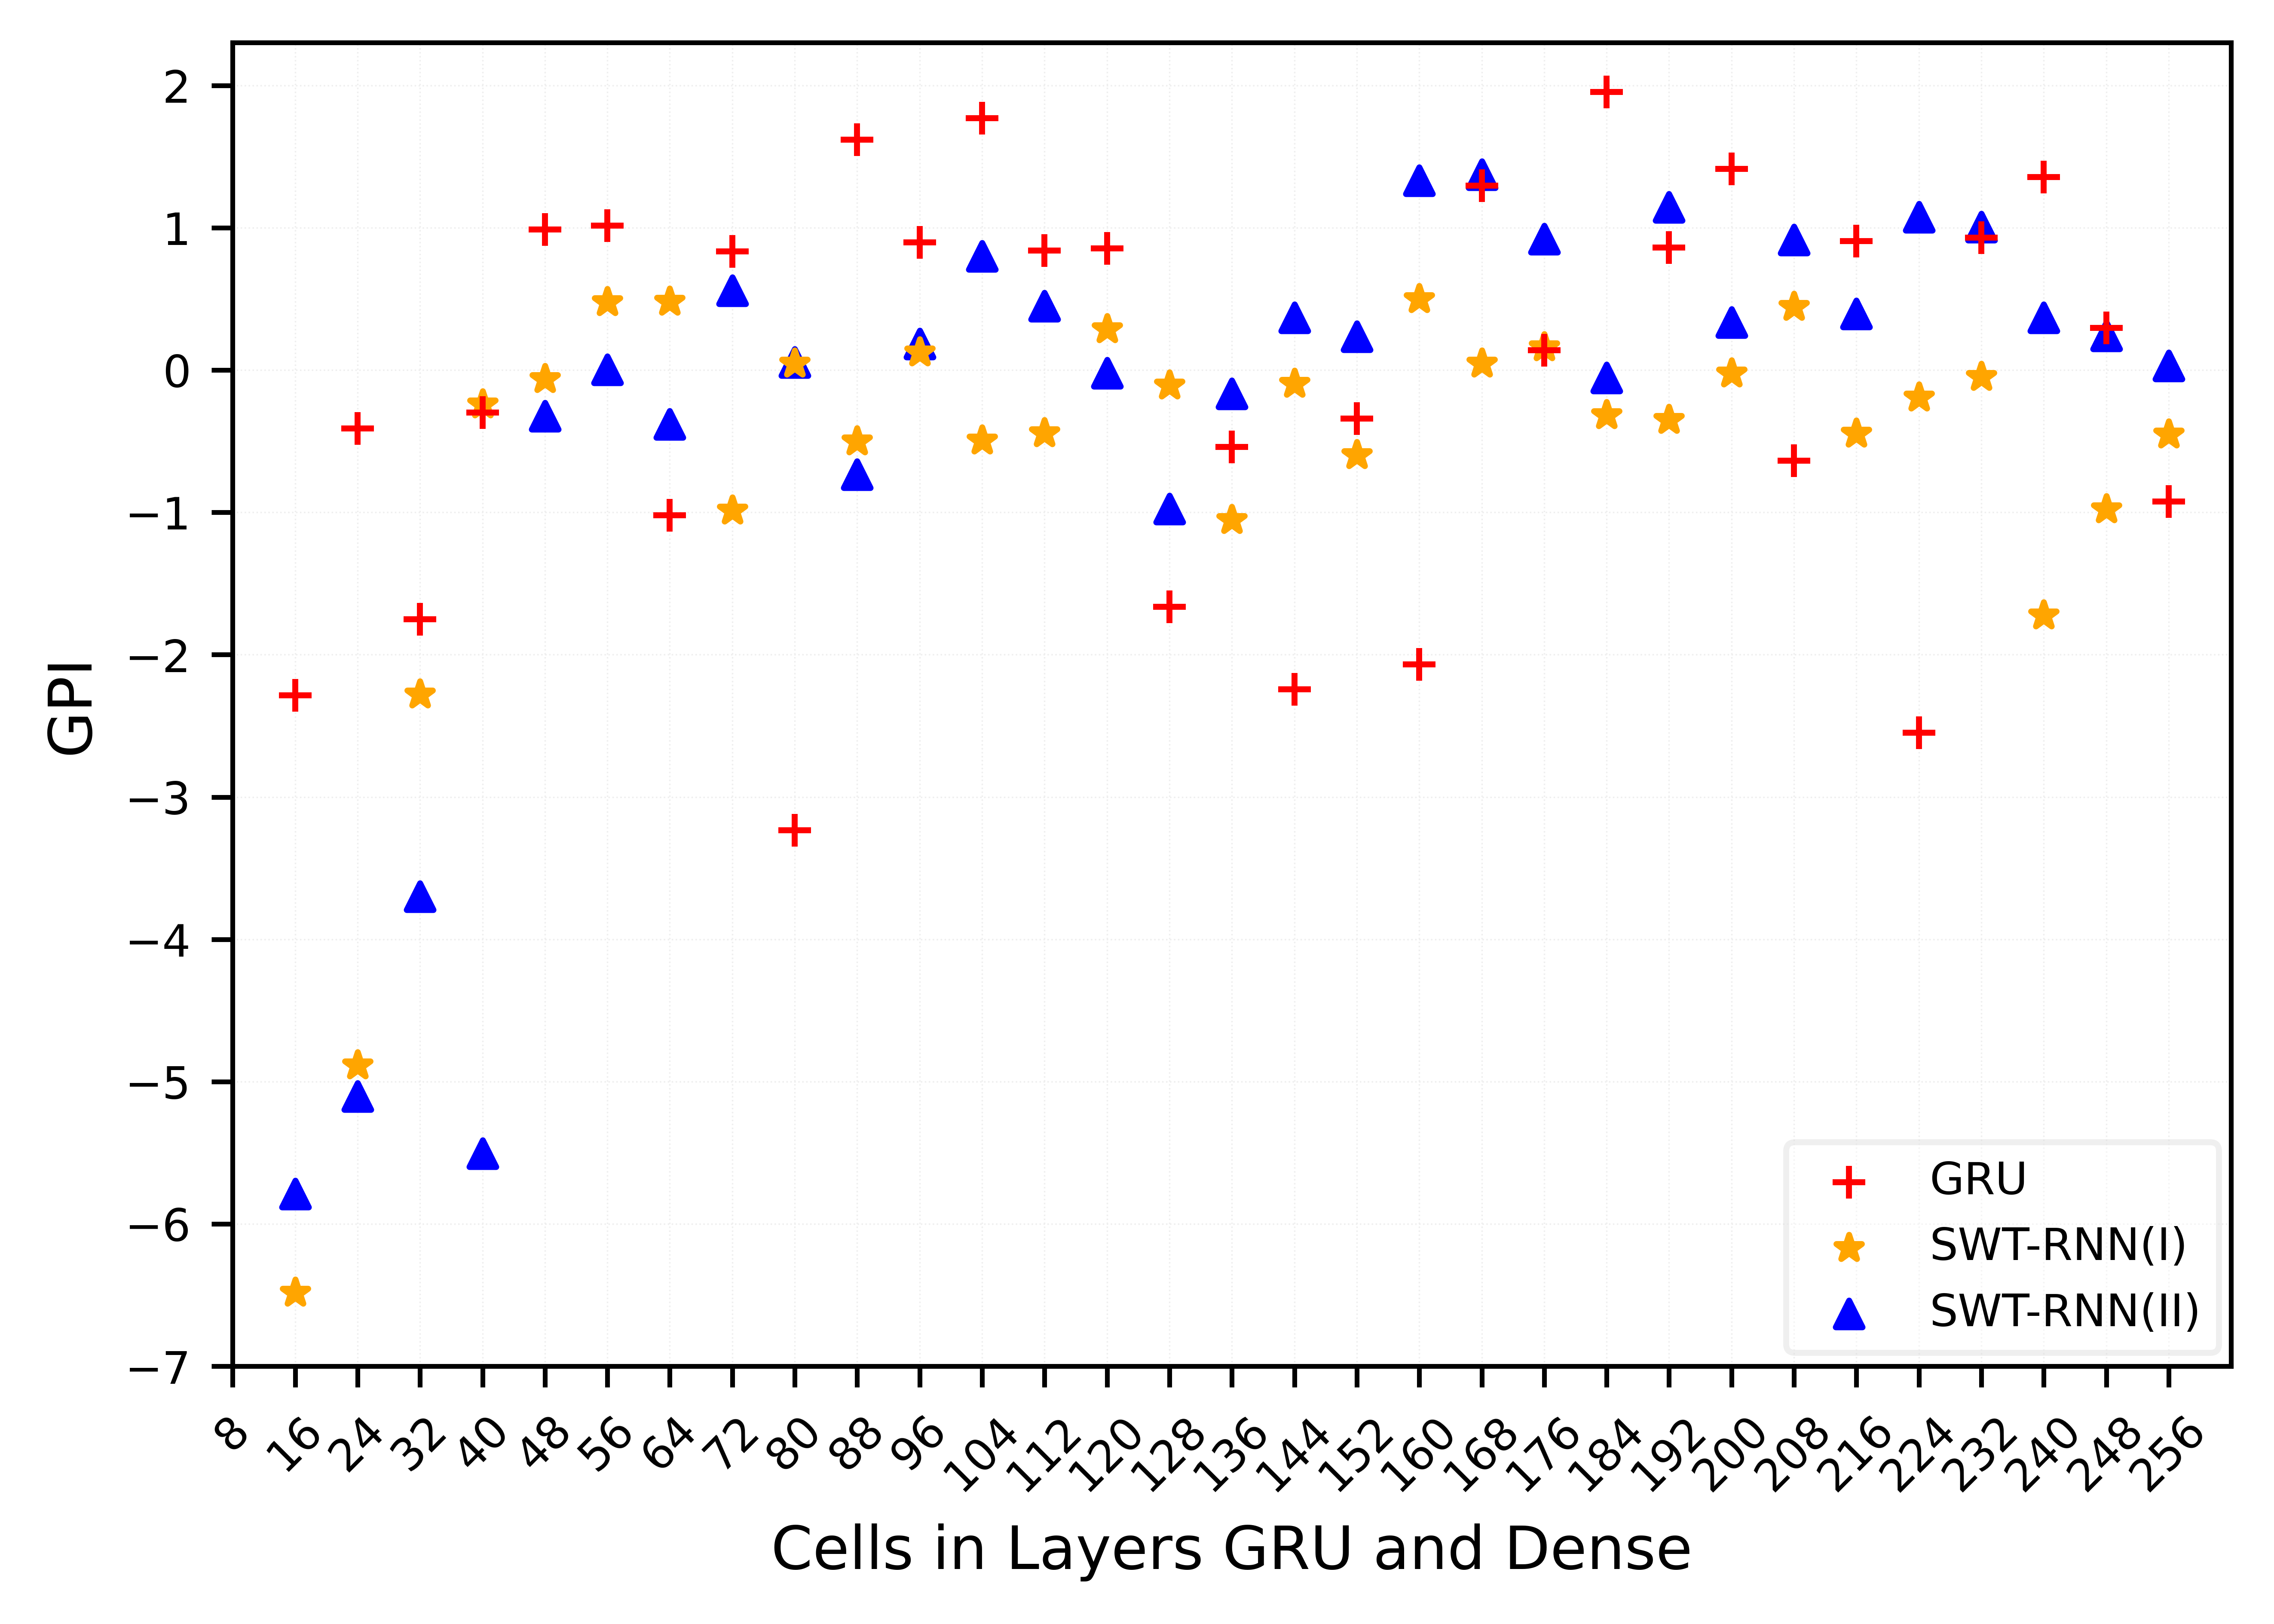

In [98]:
plt.style.use('default')
plt.figure(figsize = (6,4), dpi=1000)
plt.grid(True, which='major', color='#EEEEEE', linestyle='dotted', linewidth=0.25)
#plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.scatter(GPI_All_df['neurons'][:31],   GPI_All_df['GPI'][:31],   marker='+', linewidths=1, s=30, c='red',    label='GRU',         zorder=10)
plt.scatter(GPI_All_df['neurons'][31:62], GPI_All_df['GPI'][31:62], marker='*', linewidths=1, s=20, c='orange', label='SWT-RNN(I)',  zorder=7)
plt.scatter(GPI_All_df['neurons'][62:],   GPI_All_df['GPI'][62:],   marker='^', linewidths=1, s=20, c='b',      label='SWT-RNN(II)', zorder=5)
#plt.legend(['GRU', 'SWT-RNN(I)', 'SWT-RNN(II)'], fontsize=16)
plt.ylabel('GPI', fontsize=10)
plt.xlabel('Cells in Layers GRU and Dense', fontsize=10)
#plt.minorticks_on()

plt.xticks(fontsize=7.5, rotation=45)
plt.yticks(fontsize=7.5)
plt.xticks(np.arange(8, 264, 8));
plt.yticks(np.arange(-7, 2.3, 1));
#
plt.xlim(8,264)
plt.ylim(-7, 2.3);
plt.legend(bbox_to_anchor=(.994, 0.01),
           loc='lower right', ncols=1,  borderaxespad=0., fontsize=7.5, frameon=True, framealpha=0.4, edgecolor='0.85')
#path_fig ='D:/Users/Dario/OneDrive/DARIO Computador/UnB/Doutorado/Projeto eolica/Wavelet-GRU-RNN/figuras/'
path_fig ='C:/Users/choco/OneDrive/DARIO Computador/UnB/Doutorado/Projeto eolica/Wavelet-GRU-RNN/figuras/'
plt.savefig(path_fig+'New_figure_GPI.pdf', dpi=1000, format='pdf', bbox_inches='tight')

# FIN de Concateno as três tabelas e calculo o GPI 

In [88]:
hist_model_GRU=[]
hist_model_GRU =  pd.DataFrame(results, columns=['neurons', 'mse', 'mae', 'mape', 'r_square'])
hist_model_GRU.index.rename('Model', inplace=True)
hist_model_GRU

neurons       mse       mae      mape  r_square
Model                                                
0          16  0.130918  0.222496  8.186609  0.972095
1          24  0.117130  0.212048  7.803240  0.975034
2          32  0.125021  0.219394  7.984739  0.973352
3          40  0.117592  0.212988  7.967626  0.974936
4          48  0.107443  0.205290  7.693429  0.977099
5          56  0.107121  0.204293  7.694522  0.977167
6          64  0.121594  0.218554  7.965438  0.974083
7          72  0.106698  0.205661  7.657277  0.977258
8          80  0.134927  0.229747  8.257413  0.971241
9          88  0.103399  0.201130  7.755679  0.977961
10         96  0.107431  0.205584  7.753579  0.977102
11        104  0.101973  0.200757  7.575178  0.978265
12        112  0.108981  0.205653  7.569692  0.976771
13        120  0.105608  0.206218  7.536761  0.977490
14        128  0.124222  0.217333  7.962976  0.973523
15        136  0.116075  0.215163  8.084835  0.975259
16        144  0.130184  0.221248  8.029819  0.972252
17        152  0.115792  0.213867  8.083020  0.975319
18        160  0.127040  0.221699  8.144061  0.972922
19        168  0.106240  0.203518  7.490180  0.977355
20        176  0.111501  0.208224  7.650587  0.976234
21        184  0.102707  0.200448  7.583114  0.978108
22        192  0.108133  0.207191  7.610440  0.976952
23        200  0.105154  0.202794  7.582344  0.977587
24        208  0.115239  0.214474  7.859700  0.975437
25        216  0.108201  0.205452  7.801912  0.976937
26        224  0.128210  0.223974  8.012650  0.972672
27        232  0.107766  0.206181  7.468257  0.977030
28        240  0.104581  0.201202  7.660594  0.977709
29        248  0.112458  0.209459  7.657264  0.976030
30        256  0.121536  0.215072  7.982825  0.974095

In [ ]:
hist_GRU['loss'].iloc[-1]

0.11331398040056229

In [ ]:
hist_GRU['loss'][hist_GRU.index[-1]]

0.11331398040056229

In [ ]:
# hist_GRU_models['Model'] = np.arange(1,11).tolist()

In [34]:
# hist_GRU_models.set_index('Model', inplace=True)
hist_GRU_models.index.rename('Model', inplace=True)
hist_GRU_models

loss       mae      mape       mse  r_square  accuracy  val_loss  \
Model                                                                         
0      0.159119  0.247876  8.179738  0.159119  0.967246  0.000672  0.161162   
1      0.152436  0.243917  8.145257  0.152436  0.968622  0.000672  0.153894   
2      0.146244  0.238720  8.017177  0.146244  0.969896  0.000681  0.147927   
3      0.148551  0.241788  8.093172  0.148551  0.969421  0.000662  0.150193   
4      0.145540  0.238510  8.008060  0.145540  0.970041  0.000681  0.147261   
5      0.136875  0.232243  7.843996  0.136875  0.971825  0.000672  0.140124   
6      0.137412  0.232410  7.845084  0.137412  0.971714  0.000691  0.137147   
7      0.155033  0.249375  8.271071  0.155033  0.968087  0.000662  0.160177   
8      0.144837  0.239506  8.057852  0.144837  0.970186  0.000691  0.147346   
9      0.153879  0.248607  8.269319  0.153879  0.968325  0.000662  0.157639   
10     0.159119  0.247876  8.179738  0.159119  0.967246  0.000672  0.161162   
11     0.152436  0.243917  8.145257  0.152436  0.968622  0.000672  0.153894   
12     0.146244  0.238720  8.017177  0.146244  0.969896  0.000681  0.147927   
13     0.148551  0.241788  8.093172  0.148551  0.969421  0.000662  0.150193   
14     0.145540  0.238510  8.008060  0.145540  0.970041  0.000681  0.147261   
15     0.136875  0.232243  7.843996  0.136875  0.971825  0.000672  0.140124   
16     0.137412  0.232410  7.845084  0.137412  0.971714  0.000691  0.137147   
17     0.155033  0.249375  8.271071  0.155033  0.968087  0.000662  0.160177   
18     0.144837  0.239506  8.057852  0.144837  0.970186  0.000691  0.147346   
19     0.153879  0.248607  8.269319  0.153879  0.968325  0.000662  0.157639   
20     0.143564  0.238740  8.062440  0.143564  0.970448  0.000681  0.146293   
21     0.140702  0.236236  7.957083  0.140702  0.971037  0.000691  0.143086   
22     0.141515  0.237170  7.988173  0.141515  0.970870  0.000681  0.143579   
23     0.147265  0.242702  8.097610  0.147265  0.969686  0.000672  0.145923   
24     0.130753  0.229273  7.785770  0.130753  0.973085  0.000700  0.131411   
25     0.134440  0.231441  7.815422  0.134440  0.972326  0.000681  0.159342   
26     0.131703  0.229343  7.727553  0.131703  0.972889  0.000700  0.133009   
27     0.138294  0.236489  7.958686  0.138294  0.971533  0.000691  0.159415   
28     0.136805  0.234701  7.908704  0.136805  0.971839  0.000691  0.154128   
29     0.122485  0.222861  7.608210  0.122485  0.974787  0.000700  0.121252   
30     0.140539  0.236905  7.979427  0.140539  0.971070  0.000681  0.143279   
31     0.136202  0.235262  7.935596  0.136202  0.971963  0.000672  0.179306   
32     0.145660  0.241915  8.110354  0.145660  0.970016  0.000662  0.153475   
33     0.140667  0.237050  8.006370  0.140667  0.971044  0.000681  0.145184   
34     0.125587  0.225060  7.690950  0.125587  0.974148  0.000691  0.130036   
35     0.140724  0.238823  8.024873  0.140724  0.971033  0.000691  0.315391   
36     0.120411  0.221005  7.569481  0.120411  0.975214  0.000691  0.116084   
37     0.149556  0.246701  8.246736  0.149556  0.969214  0.000662  0.155226   
38     0.138456  0.236012  7.942039  0.138456  0.971499  0.000691  0.144046   
39     0.154398  0.251106  8.364879  0.154398  0.968218  0.000662  0.162334   

        val_mae   val_mape   val_mse  val_r_square  val_accuracy  
Model                                                             
0      0.248539   8.247608  0.161162      0.966059      0.000883  
1      0.243194   8.218551  0.153894      0.967590      0.000883  
2      0.238868   8.099778  0.147927      0.968847      0.000883  
3      0.238607   8.154493  0.150193      0.968369      0.000883  
4      0.238392   8.099092  0.147261      0.968987      0.000883  
5      0.234949   7.874479  0.140124      0.970490      0.000883  
6      0.229240   7.837132  0.137147      0.971117      0.000844  
7      0.258902   8.921969  0.160177      0.966267      0.000883  
8      0.239642   8.36

In [ ]:
model_GRU_simple.evaluate(teste_x_only_original, teste_y, verbose=1)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
model_GRU_simple_evaluate=[]

for i in range(1):
    model_GRU_simple_evaluate.append(model_GRU_simple[i].evaluate(teste_x_only_original, teste_y, verbose=1))

TypeError: 'Sequential' object is not subscriptable

In [ ]:
model_GRU_simple_evaluate_df = pd.DataFrame(model_GRU_simple_evaluate, columns=['loss', 'mae', 'mape', 'mse', 'r_square'])
model_GRU_simple_evaluate_df.index.rename('Model', inplace=True)
model_GRU_simple_evaluate_df

loss       mae       mape       mse  r_square
Model                                                   
0      0.119297  0.218074   8.190801  0.119297  0.974572
1      0.125662  0.222106   8.296053  0.125662  0.973216
2      0.120467  0.218305   8.204532  0.120467  0.974323
3      0.157319  0.247924   9.228931  0.157319  0.966468
4      0.122072  0.220352   8.374768  0.122072  0.973981
5      0.202344  0.291151   9.947466  0.202344  0.956871
6      0.272372  0.361106  12.139384  0.272372  0.941945
7      0.144620  0.237330   8.784064  0.144620  0.969175
8      0.157145  0.255897   8.828018  0.157145  0.966505
9      0.121372  0.215656   8.034962  0.121372  0.974130

Para lembrar

......................................................................................

In [ ]:
 xcxc = pd.DataFrame(history_only_original_acum[0].history).iloc[-1]

In [ ]:
xcxc.shape

(5,)

In [ ]:
list(history_only_original_acum[0].history)

['loss', 'mae', 'mape', 'mse', 'r_square']

In [ ]:
list(history_only_original_acum[0].history.values())[4][32]

0.9765739440917969

......................................................................................

In [ ]:
model_GRU_simple_predict_y = model_GRU_simple[0].predict(teste_x_only_original)

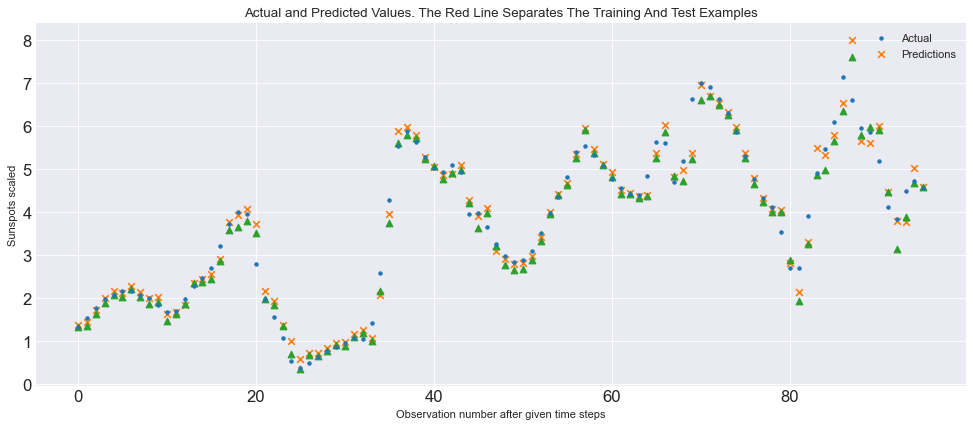

In [ ]:
plot_result(teste_y.reshape(len(teste_y))[0:96], model_GRU_simple_predict_y.reshape(len(teste_y))[0:96])
plt.scatter(range(0,96), predict_y.reshape(len(teste_y))[0:96], marker='^')


# WTGRU model with only signals resulting from wavelet transform

In [ ]:
train_x

In [ ]:
history_model_WTGRU_only_WTinputs  = []
model_WTGRU_only_WTinputs = []
OUT_STEPS = 1
nodos = 8

for i in range(30):
    nodos = nodos+8
    My_model_path = '/content/drive/MyDrive/model_GRU_Only_coeff' + str(nodos) + '.h5'
    m = tf.keras.Sequential([
                    # Shape [batch, time, features] => [batch, lstm_units].
                    # Adding more `lstm_units` just overfits more quickly.
                    tf.keras.layers.GRU(nodos, return_sequences=False),
                    # Shape => [batch, out_steps*features].
                    tf.keras.layers.Dense(OUT_STEPS,
                    kernel_initializer=tf.initializers.zeros()),
                    # Shape => [batch, out_steps, features].
                    tf.keras.layers.Reshape([OUT_STEPS, 1])
                    ])
    model_WTGRU_only_WTinputs.append(m)
    history_only_original = compile_and_fit(model_WTGRU_only_WTinputs[i], train_x, train_y, My_model_path)
    history_model_WTGRU_only_WTinputs.append(history_only_original)

Epoch 1/100
408/408 [==============================] - ETA: 0s - loss: 3.3880 - mae: 1.3533 - mape: 52.3103 - mse: 3.3880 - r_square: 0.3026 - accuracy: 6.9083e-04
Epoch 1: val_mape improved from inf to 14.90654, saving model to /content/drive/MyDrive/model_GRU_Only_coeff192.h5
408/408 [==============================] - 23s 24ms/step - loss: 3.3880 - mae: 1.3533 - mape: 52.3103 - mse: 3.3880 - r_square: 0.3026 - accuracy: 6.9083e-04 - val_loss: 0.2956 - val_mae: 0.3949 - val_mape: 14.9065 - val_mse: 0.2956 - val_r_square: 0.9377 - val_accuracy: 8.8271e-04
Epoch 2/100
405/408 [============================>.] - ETA: 0s - loss: 0.2114 - mae: 0.3130 - mape: 10.7029 - mse: 0.2114 - r_square: 0.9565 - accuracy: 6.8480e-04
Epoch 2: val_mape improved from 14.90654 to 9.68712, saving model to /content/drive/MyDrive/model_GRU_Only_coeff192.h5
408/408 [==============================] - 9s 22ms/step - loss: 0.2112 - mae: 0.3128 - mape: 10.6981 - mse: 0.2112 - r_square: 0.9565 - accuracy: 6.8124e-0

In [ ]:
history_model_WTGRU_only_WTinputs

In [ ]:
model_WTGRU_only_WTinputs_evaluate=[]

for i in range(10):
    model_WTGRU_only_WTinputs_evaluate.append(model_WTGRU_only_WTinputs[i].evaluate(teste_x, teste_y, verbose=1))

In [ ]:
model_WTGRU_only_WTinputs_evaluate_df = pd.DataFrame(model_WTGRU_only_WTinputs_evaluate, columns=['loss', 'mae', 'mape', 'mse', 'r_square'])
model_WTGRU_only_WTinputs_evaluate_df.index.rename('Model', inplace=True)
model_WTGRU_only_WTinputs_evaluate_df

loss       mae      mape       mse  r_square
Model                                                  
0      0.141294  0.245659  9.466305  0.141294  0.969884
1      0.136973  0.241830  8.898893  0.136973  0.970805
2      0.127738  0.235567  8.935685  0.127738  0.972773
3      0.134358  0.235452  8.698762  0.134358  0.971362
4      0.130715  0.237315  9.046906  0.130715  0.972138
5      0.140334  0.245285  8.547893  0.140334  0.970088
6      0.134798  0.237515  8.989694  0.134798  0.971268
7      0.132678  0.236337  9.389786  0.132678  0.971720
8      0.131425  0.234743  8.799199  0.131425  0.971987
9      0.134496  0.237841  8.768588  0.134496  0.971332

# WT GRU with coeff + original

In [8]:
train_x_with_original.shape

NameError: ignored

In [ ]:
len(train_y)

130278

In [26]:
history_model_WTGRU_WT_original  = []
model_WTGRU_WT_original = []
OUT_STEPS = 1
nodos = 120
for i in range(1):
    nodos = nodos+8
    My_model_path = 'G:/Meu Drive/model_GRU_with_coeff_original/Rev256_model_GRU_with_coeff_original' + str(nodos) + '.h5'
    m = tf.keras.Sequential([
                    # Shape [batch, time, features] => [batch, lstm_units].
                    # Adding more `lstm_units` just overfits more quickly.
                    tf.keras.layers.GRU(nodos, return_sequences=False),
                    # Shape => [batch, out_steps*features].
                    tf.keras.layers.Dense(OUT_STEPS,
                    kernel_initializer=tf.initializers.zeros()),
                    # Shape => [batch, out_steps, features].
                    tf.keras.layers.Reshape([OUT_STEPS, 1])
                    ])
    model_WTGRU_WT_original.append(m)
    history = compile_and_fit(model_WTGRU_WT_original[i], train_x_with_original, train_y, My_model_path, patience=30)
    history_model_WTGRU_WT_original.append(history)

Epoch 1/200
406/408 [============================>.] - ETA: 0s - loss: 2.4127 - mae: 0.9683 - mape: 31.7304 - msle: 0.1307 - logcosh: 0.5848 - chi_square: 202.1703 - mean_bias_error: 0.2705 - root_mean_squared_error: 1.5533 - r_square: 0.5035
Epoch 1: val_mape improved from inf to 10.79208, saving model to G:/Meu Drive/model_GRU_with_coeff_original\Rev256_model_GRU_with_coeff_original128.h5
408/408 [==============================] - 15s 24ms/step - loss: 2.4067 - mae: 0.9665 - mape: 31.6669 - msle: 0.1304 - logcosh: 0.5834 - chi_square: 201.6592 - mean_bias_error: 0.2696 - root_mean_squared_error: 1.5513 - r_square: 0.5046 - val_loss: 0.2250 - val_mae: 0.3242 - val_mape: 10.7921 - val_msle: 0.0097 - val_logcosh: 0.0932 - val_chi_square: 17.7055 - val_mean_bias_error: -0.1074 - val_root_mean_squared_error: 0.4744 - val_r_square: 0.9526
Epoch 2/200
407/408 [============================>.] - ETA: 0s - loss: 0.1871 - mae: 0.2854 - mape: 9.2363 - msle: 0.0086 - logcosh: 0.0776 - chi_square:

In [ ]:
del history_WTGRU_WT_original,  temp
history_WTGRU_WT_original = pd.DataFrame(columns=['loss', 'mae', 'mape', 'mse', 'r_square'])
history_WTGRU_WT_original

Empty DataFrame
Columns: [loss, mae, mape, mse, r_square]
Index: []

In [ ]:
for i in range(10):
    temp = pd.DataFrame(history_model_WTGRU_WT_original[i].history).iloc[-1]
    history_WTGRU_WT_original = history_WTGRU_WT_original.append(temp)

history_WTGRU_WT_original["Model"] = np.arange(0,10)

In [ ]:
history_WTGRU_WT_original.set_index('Model', inplace=True)
history_WTGRU_WT_original

loss       mae      mape       mse  r_square
Model                                                  
0      0.112700  0.213725  7.379189  0.112700  0.976701
1      0.112344  0.213435  7.365473  0.112344  0.976775
2      0.117316  0.216912  7.435171  0.117316  0.975747
3      0.115155  0.214588  7.381890  0.115155  0.976193
4      0.126275  0.223932  7.591225  0.126275  0.973895
5      0.125998  0.224408  7.600643  0.125998  0.973952
6      0.115280  0.214984  7.374678  0.115280  0.976168
7      0.125339  0.223959  7.563516  0.125339  0.974088
8      0.127069  0.224574  7.570026  0.127069  0.973730
9      0.118095  0.218783  7.493869  0.118095  0.975585

In [ ]:
model_WTGRU_WT_original_evaluate=[]

for i in range(10):
    model_WTGRU_WT_original_evaluate.append(model_WTGRU_WT_original[i].evaluate(teste_x_with_original, teste_y, verbose=1))

In [ ]:
model_WTGRU_WT_original_evaluate_df = pd.DataFrame(model_WTGRU_WT_original_evaluate, columns=['loss', 'mae', 'mape', 'mse', 'r_square'])
model_WTGRU_WT_original_evaluate_df.index.rename('Model', inplace=True)
model_WTGRU_WT_original_evaluate_df

loss       mae      mape       mse  r_square
Model                                                  
0      0.119630  0.218284  8.255258  0.119630  0.974501
1      0.119059  0.217145  8.264544  0.119059  0.974623
2      0.120659  0.219098  8.290874  0.120659  0.974282
3      0.122585  0.218739  8.095741  0.122585  0.973871
4      0.127243  0.223505  8.175192  0.127243  0.972879
5      0.132924  0.228783  8.512484  0.132924  0.971668
6      0.121532  0.221613  8.153748  0.121532  0.974096
7      0.133400  0.233171  8.970108  0.133400  0.971566
8      0.127853  0.224909  8.110957  0.127853  0.972749
9      0.125507  0.224907  8.245588  0.125507  0.973249

In [ ]:
model_WTGRU_WT_original_predict_y = model_WTGRU_WT_original[3].predict(teste_x_with_original)

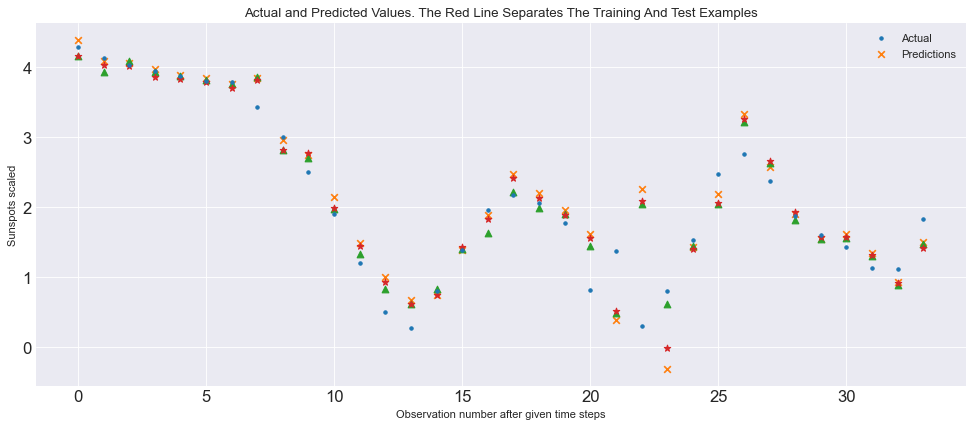

In [ ]:
plot_result(teste_y.reshape(len(teste_y))[96:130], model_GRU_simple_predict_y.reshape(len(teste_y))[96:130])
plt.scatter(range(0,34), predict_y.reshape(len(teste_y))[96:130], marker='^')
plt.scatter(range(0,34), model_WTGRU_WT_original_predict_y.reshape(len(teste_y))[96:130], marker='*')

# Modelo com treinameto WT incorreto

In [ ]:
pywt.swt_max_level(len(tt))

7

In [ ]:
coeffs_all_signal = pywt.swt(tt[:], wavelet, level=4, trim_approx=True, norm=True)


In [ ]:
type(coeffs_all_signal)

list

In [ ]:
del ap_data2

In [ ]:
ap_data2 = pd.DataFrame()
ap_data2['Wind_speed'] = list(ap_data['Wind Speed'][:])

In [ ]:
ap_data2['A1'] = coeffs_all_signal[0]
ap_data2['D1'] = coeffs_all_signal[1]
ap_data2['D2'] = coeffs_all_signal[2]
ap_data2['D3'] = coeffs_all_signal[3]
ap_data2['D4'] = coeffs_all_signal[4]

In [ ]:
ap_data2

Wind_speed        A1        D1        D2        D3        D4
0             1.79  2.131959 -1.038422 -0.775700  0.084934  0.132601
1             1.64  1.969950 -0.898626 -0.565987 -0.475868  0.065197
2             1.30  1.845404 -0.728447 -0.219511 -0.648006 -0.297960
3             0.82  1.756232 -0.495681  0.056436 -0.310233 -0.260854
4             1.25  1.714752 -0.228865  0.147957  0.072208 -0.003187
...            ...       ...       ...       ...       ...       ...
186235        1.68  3.375801 -1.464434 -0.462516 -0.344586 -0.041112
186236        1.33  3.098655 -1.479732 -0.264482 -0.477122 -0.065131
186237        1.02  2.812798 -1.408924 -0.282637 -0.253163 -0.166734
186238        0.89  2.544301 -1.286306 -0.468851  0.218222 -0.135885
186239        1.20  2.318181 -1.163708 -0.703159  0.415230  0.227093

[186240 rows x 6 columns]

In [ ]:
len(ap_data2)

186240

In [ ]:
train_x_SWT_all_signal =[ap_data2[i:i+128] for i in range(0,len(ap_data2)-129)]

In [ ]:
np.array(train_x_SWT_all_signal).shape

(186111, 128, 6)

In [ ]:
split

130278

In [ ]:
teste_x_SWT_all_signal = np.array(train_x_SWT_all_signal)[split:]

In [ ]:
teste_y_SWT_all_signal = teste_y

In [ ]:
train_x_SWT_all_signal_2 = np.array(train_x_SWT_all_signal)[0:split]

In [ ]:
train_x_SWT_all_signal_2.shape

(130278, 128, 6)

In [ ]:
train_y_SWT_all_signal_2 = train_y

In [ ]:
train_y_SWT_all_signal_2.shape

(130278, 1, 1)

In [ ]:
 model_SWT_all_signal = tf.keras.Sequential([
                    # Shape [batch, time, features] => [batch, lstm_units].
                    # Adding more `lstm_units` just overfits more quickly.
                    tf.keras.layers.GRU(32, return_sequences=False),
                    # Shape => [batch, out_steps*features].
                    tf.keras.layers.Dense(OUT_STEPS,
                    kernel_initializer=tf.initializers.zeros()),
                    # Shape => [batch, out_steps, features].
                    tf.keras.layers.Reshape([OUT_STEPS, 1])
                    ])

history_model_SWT_all_signal = compile_and_fit(model_SWT_all_signal, train_x_SWT_all_signal_2, train_y_SWT_all_signal_2)

Epoch 1/100
509/509 [==============================] - 98s 163ms/step - loss: 4.3343 - mae: 1.2541 - mape: 28.1911 - mse: 4.3343 - r_square: 0.1040
Epoch 2/100
509/509 [==============================] - 84s 165ms/step - loss: 0.1318 - mae: 0.1594 - mape: 3.6324 - mse: 0.1318 - r_square: 0.9728
Epoch 3/100
509/509 [==============================] - 87s 170ms/step - loss: 0.0365 - mae: 0.0826 - mape: 2.2303 - mse: 0.0365 - r_square: 0.9924
Epoch 4/100
509/509 [==============================] - 86s 169ms/step - loss: 0.0187 - mae: 0.0604 - mape: 1.7372 - mse: 0.0187 - r_square: 0.9961
Epoch 5/100
509/509 [==============================] - 85s 167ms/step - loss: 0.0120 - mae: 0.0492 - mape: 1.4555 - mse: 0.0120 - r_square: 0.9975
Epoch 6/100
509/509 [==============================] - 87s 171ms/step - loss: 0.0083 - mae: 0.0410 - mape: 1.2250 - mse: 0.0083 - r_square: 0.9983
Epoch 7/100
509/509 [==============================] - 88s 172ms/step - loss: 0.0059 - mae: 0.0348 - mape: 1.0453 - m

In [ ]:
history_model_SWT_all_signal = compile_and_fit(model_SWT_all_signal, train_x_SWT_all_signal_2, train_y_SWT_all_signal_2)

Epoch 1/100
509/509 [==============================] - 140s 223ms/step - loss: 1.6132e-04 - mae: 0.0058 - mape: 0.1816 - mse: 1.6132e-04 - r_square: 1.0000
Epoch 2/100
509/509 [==============================] - 127s 250ms/step - loss: 4.9332e-05 - mae: 0.0041 - mape: 0.1364 - mse: 4.9332e-05 - r_square: 1.0000
Epoch 3/100
509/509 [==============================] - 136s 268ms/step - loss: 5.3991e-05 - mae: 0.0045 - mape: 0.1463 - mse: 5.3991e-05 - r_square: 1.0000
Epoch 4/100
509/509 [==============================] - 136s 267ms/step - loss: 5.6812e-05 - mae: 0.0048 - mape: 0.1555 - mse: 5.6812e-05 - r_square: 1.0000


In [ ]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_36 (GRU)                (None, 128)               51840     
                                                                 
 dense_36 (Dense)            (None, 1)                 129       
                                                                 
 reshape_35 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 51,969
Trainable params: 51,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_SWT_all_signal.layers[1].get_config()

{'name': 'dense_44',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [ ]:
teste_y_SWT_all_signal[0:-2]

array([[1.31]])

In [ ]:
train_y_SWT_all_signal_2[130277]

array([[1.2]])

In [ ]:
model_SWT_all_signal.evaluate(teste_x_SWT_all_signal, teste_y_SWT_all_signal[0:-1])

1745/1745 [==============================] - 72s 25ms/step - loss: 4.3496e-05 - mae: 0.0031 - mape: 0.1152 - mse: 4.3496e-05 - r_square: 1.0000ETA: 22s - loss: 5.7846e-05 - mae: 0.0032 - mape: 0.1103 -  - ETA: 18s - loss: 5. - ETA: 16s - loss: 5.2261e-05 - mae: 0.0032 - mape: 0.1 - ETA: 15s - loss: 5.1037e-05 - m - ETA: 13s - loss: 5.1828e-05 - mae: 0.0032 - mape: 0.1175 - ms - ETA: 12s - loss: 5.0495e-05 - ETA: 10s - loss: 5.1637e-05 - mae: 0.0032 - ma - ETA: 8s - loss: 4. - ETA: 4s - loss: 4.6173e-05 - mae: 0.0031 - mape: 0.1149 - mse - ETA: 2s - loss: 4.5109e-05 - mae: 0.0031 - mape: 0.1158 - mse: 4.5109e-05 - r_square: - ETA: 1s - loss: 4.4711e-05 - mae: 0.0031 - mape: 0.1154 - mse: 4.4711e-05 - r_square: 1.0 - ETA: 1s - loss: 4.4551e-05 - mae: 0.0031 - mape: 0.1151 - mse: 4.4


[4.3496442231116816e-05,
 0.0030839669052511454,
 0.11517370492219925,
 4.3496442231116816e-05,
 0.999990701675415]

In [222]:
0.4*.6

0.24

In [ ]:
predict_y_model_SWT_all_signal = model_SWT_all_signal.predict(teste_x_SWT_all_signal)

In [ ]:
plt.style.use('default')

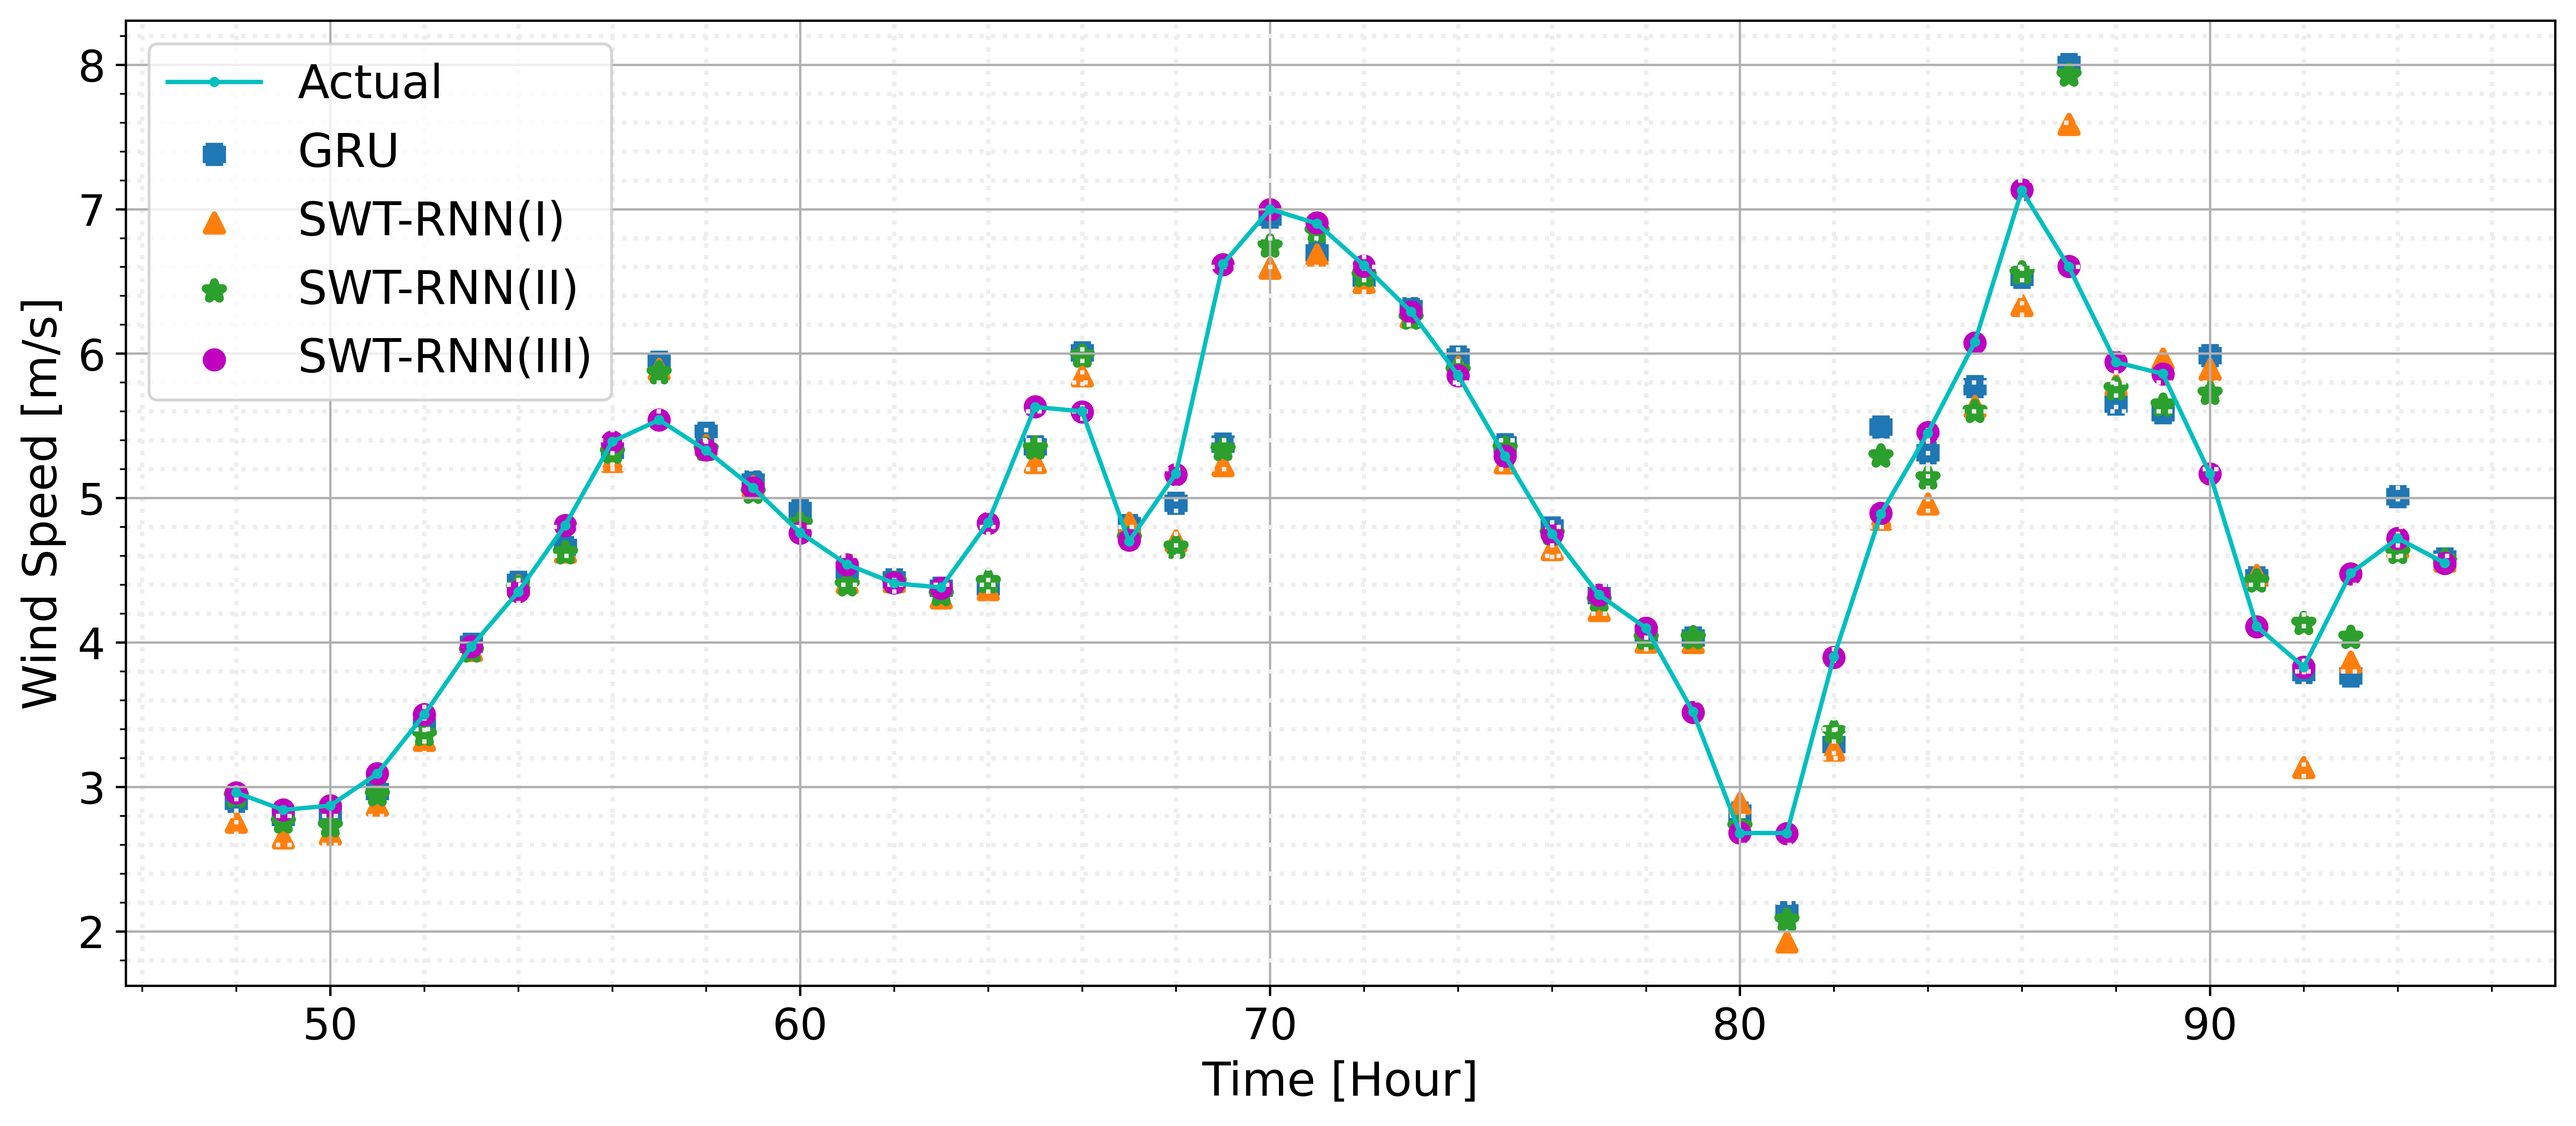

In [ ]:
#plot_result(teste_y.reshape(len(teste_y))[96:130], model_GRU_simple_predict_y.reshape(len(teste_y))[96:130])
plt.figure(figsize=(15, 6), dpi=600)
plt.plot(range(48,96), teste_y.reshape(len(teste_y))[48:96], color='c', marker='.', markersize=5)
plt.scatter(range(48,96), model_GRU_simple_predict_y.reshape(len(teste_y))[48:96], marker='+', linewidths=8)
plt.scatter(range(48,96), predict_y.reshape(len(teste_y))[48:96], marker='^', linewidths=2)
plt.scatter(range(48,96), model_WTGRU_WT_original_predict_y.reshape(len(teste_y))[48:96], marker='*', linewidths=3)
plt.scatter(range(48,96), predict_y_model_SWT_all_signal.reshape(len(teste_y)-1)[48:96], color='m', marker='o', linewidths=2)
plt.legend(['Actual', 'GRU', 'SWT-RNN(I)', 'SWT-RNN(II)', 'SWT-RNN(III)'], fontsize=16)
plt.xlabel('Time [Hour]', fontsize=16)
plt.ylabel('Wind Speed [m/s]', fontsize=16)
#plt.title ('Actual and Predicted Values')

plt.minorticks_on()
plt.grid(True, which='major')
plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=1.5)
#plt.rcParams.update({'font.size': 10})

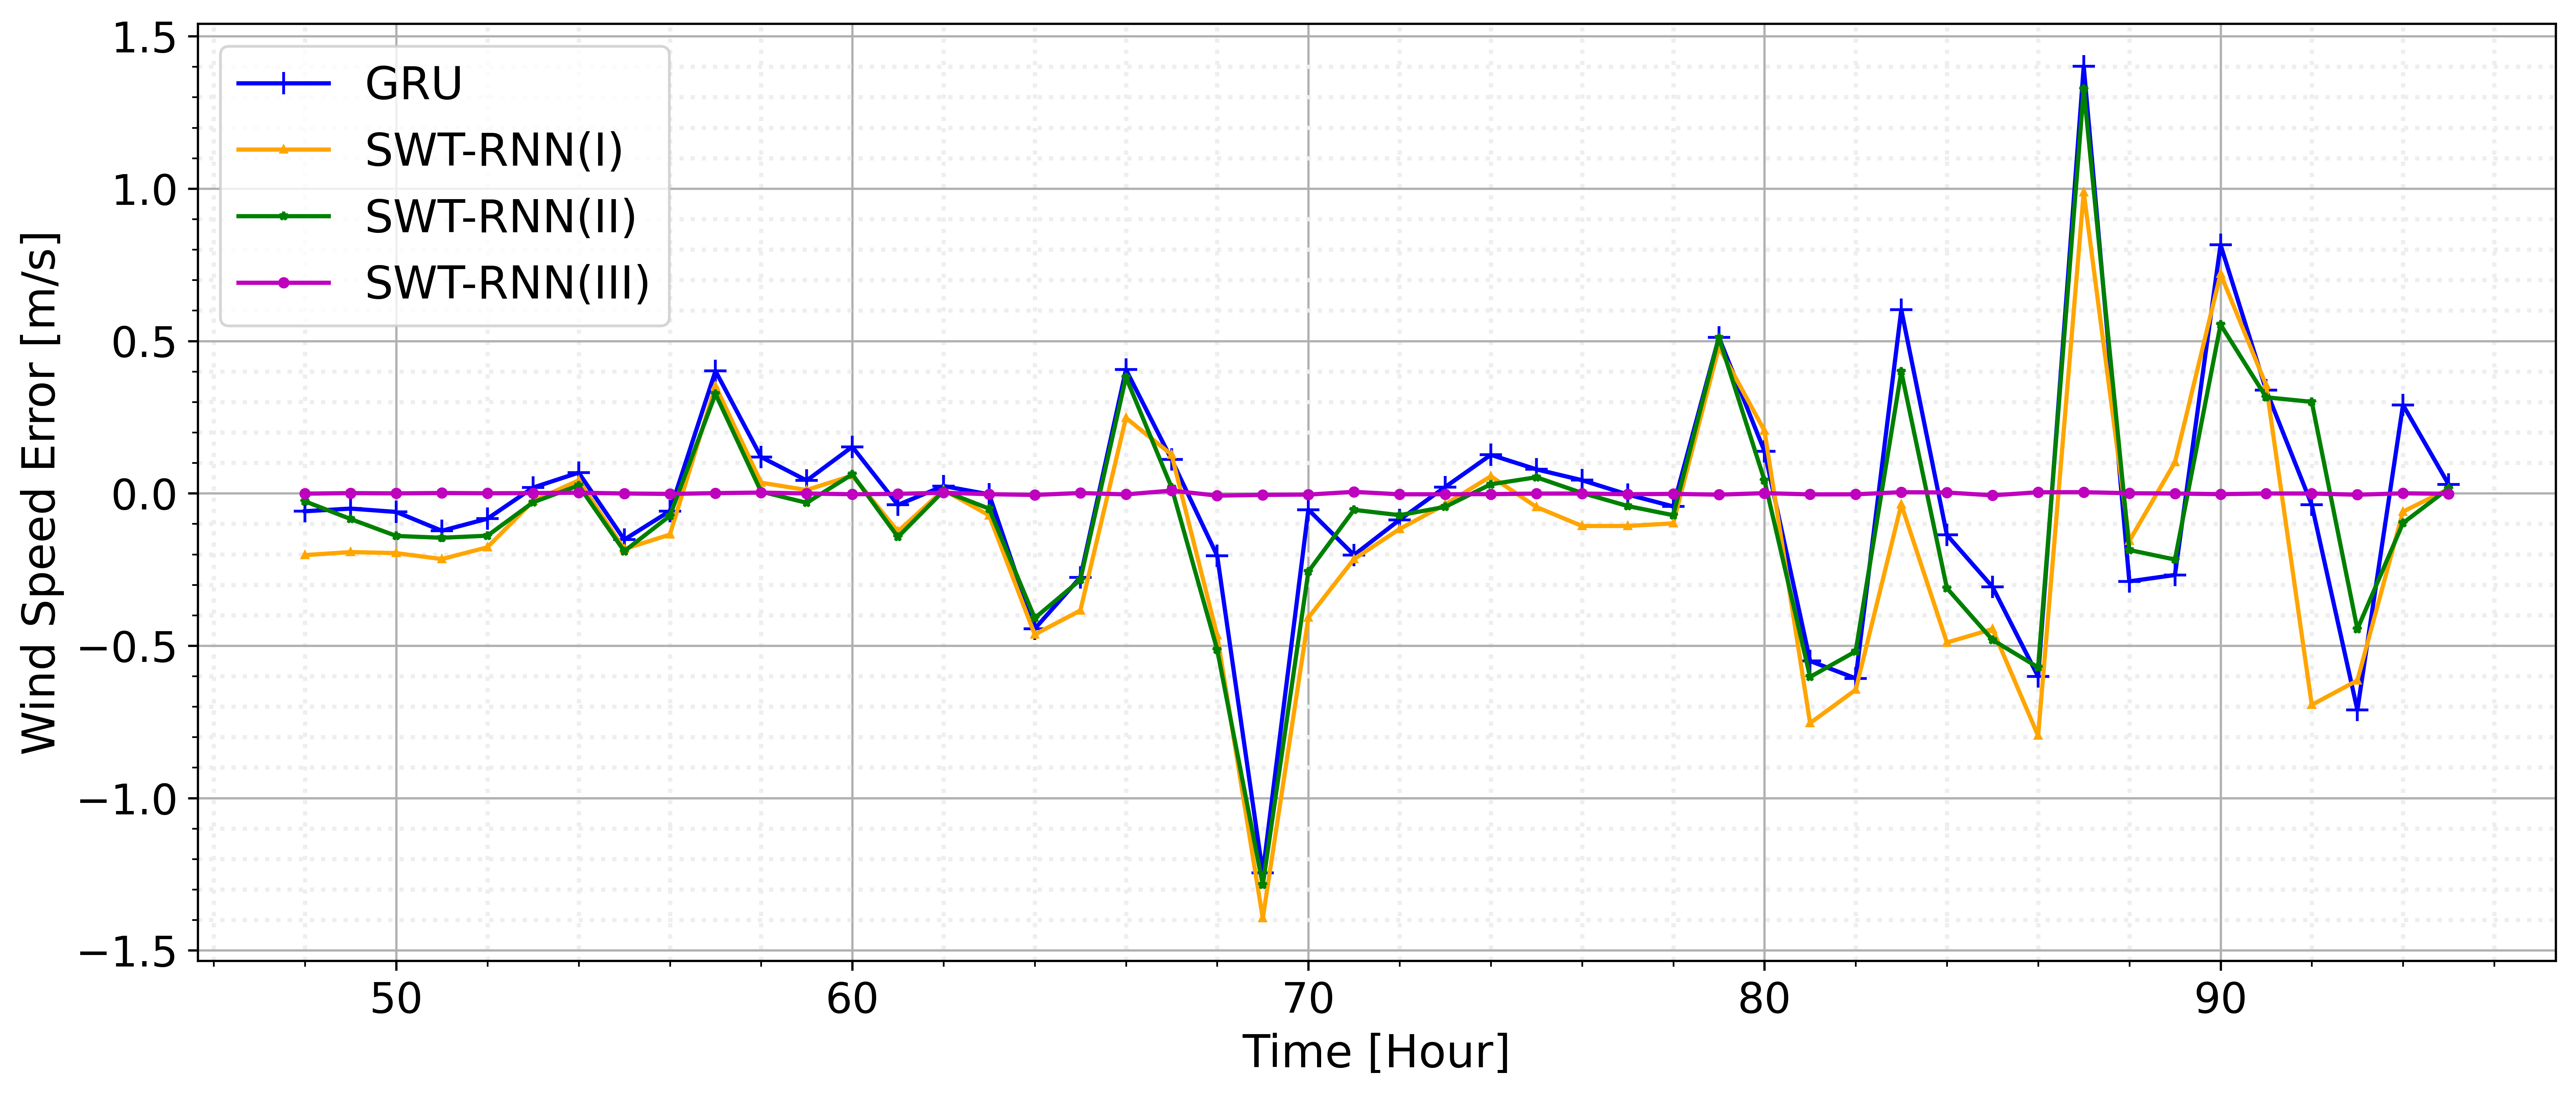

In [ ]:
A=-teste_y.reshape(len(teste_y))[48:96]+model_GRU_simple_predict_y.reshape(len(teste_y))[48:96]
B=-teste_y.reshape(len(teste_y))[48:96]+predict_y.reshape(len(teste_y))[48:96]
C=-teste_y.reshape(len(teste_y))[48:96]+model_WTGRU_WT_original_predict_y.reshape(len(teste_y))[48:96]
D=-teste_y.reshape(len(teste_y))[48:96]+predict_y_model_SWT_all_signal.reshape(len(teste_y)-1)[48:96]


plt.figure(figsize=(15, 6), dpi=600)
plt.plot(range(48,96), A, color='b', marker='+', markersize=8)
plt.plot(range(48,96), B, color='orange', marker='^', markersize=2)
plt.plot(range(48,96), C, color='g', marker='*', markersize=3)
plt.plot(range(48,96), D, color='m', marker='o', markersize=3)

plt.legend(['GRU', 'SWT-RNN(I)', 'SWT-RNN(II)', 'SWT-RNN(III)'], fontsize=16)
plt.xlabel('Time [Hour]', fontsize=16)
plt.ylabel('Wind Speed Error [m/s]', fontsize=16)

plt.minorticks_on()
plt.grid(True, which='major')
plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=1.5)

plt.rcParams.update({'font.size': 20})

In [ ]:
disterro_A =-teste_y.reshape(len(teste_y))[:]+model_GRU_simple_predict_y.reshape(len(teste_y))[:]
disterro_B=-teste_y.reshape(len(teste_y))[:]+predict_y.reshape(len(teste_y))[:]
disterro_C=-teste_y.reshape(len(teste_y))[:]+model_WTGRU_WT_original_predict_y.reshape(len(teste_y))[:]
disterro_D=-teste_y.reshape(len(teste_y))[:-1]+predict_y_model_SWT_all_signal.reshape(len(teste_y)-1)[:]

In [ ]:
wA = np.ones_like(disterro_A)/len(disterro_A)
wB = np.ones_like(disterro_B)/len(disterro_B)
wC = np.ones_like(disterro_C)/len(disterro_C)
wD = np.ones_like(disterro_D)/len(disterro_D)

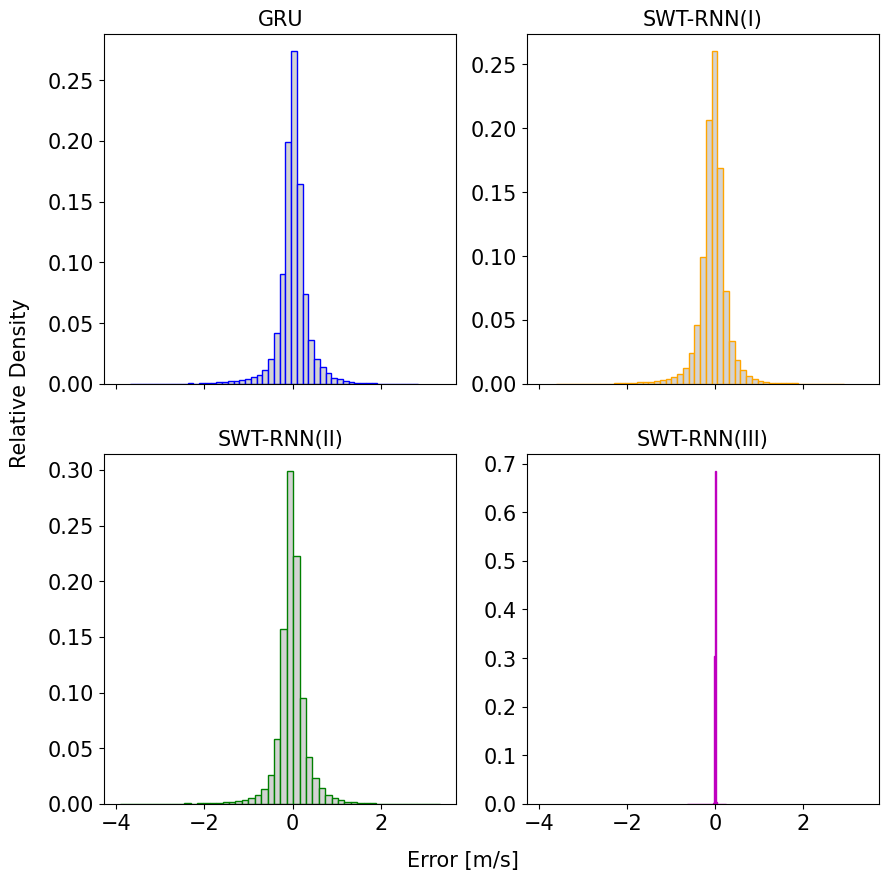

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex='all')
axs[0, 0].hist(disterro_A, bins=50, color="lightgrey", edgecolor='b', weights=wA)
axs[0, 1].hist(disterro_B, bins=50, color="lightgrey", edgecolor='orange', weights=wB)
axs[1, 0].hist(disterro_C, bins=50, color="lightgrey", edgecolor='g', weights=wC)
axs[1, 1].hist(disterro_D, bins=50, color="lightgrey", edgecolor='m', weights=wD)
plt.text(-16, 0.7 , 'Relative Density', rotation=90, fontsize='15')
plt.text(-7, -0.13 , 'Error [m/s]', fontsize='15')
axs[0,0].set_title('GRU', fontsize='15')
axs[0,1].set_title('SWT-RNN(I)', fontsize='15')
axs[1,0].set_title('SWT-RNN(II)', fontsize='15')
axs[1,1].set_title('SWT-RNN(III)', fontsize='15')

axs[0, 0].tick_params(axis='both', which='major', labelsize=15)
axs[0, 1].tick_params(axis='both', which='major', labelsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
axs[1, 1].tick_params(axis='both', which='major', labelsize=15)

#plt.legend(['GRU', 'SWT-RNN(I)', 'SWT-RNN(II)', 'SWT-RNN(III)'], fontsize=16)
#plt.xlabel('error [m/s]', fontsize=16)
#plt.ylabel('PMF', fontsize=16)
#plt.rcParams.update({'font.size': 15})

In [ ]:
disterro_A =-+
disterro_B=-teste_y.reshape(len(teste_y))[:]+predict_y.reshape(len(teste_y))[:]
disterro_C=-teste_y.reshape(len(teste_y))[:]+model_WTGRU_WT_original_predict_y.reshape(len(teste_y))[:]
disterro_D=-teste_y.reshape(len(teste_y))[:-1]+predict_y_model_SWT_all_signal.reshape(len(teste_y)-1)[:]

Text(-24, 13, 'Prediction [m/s]')

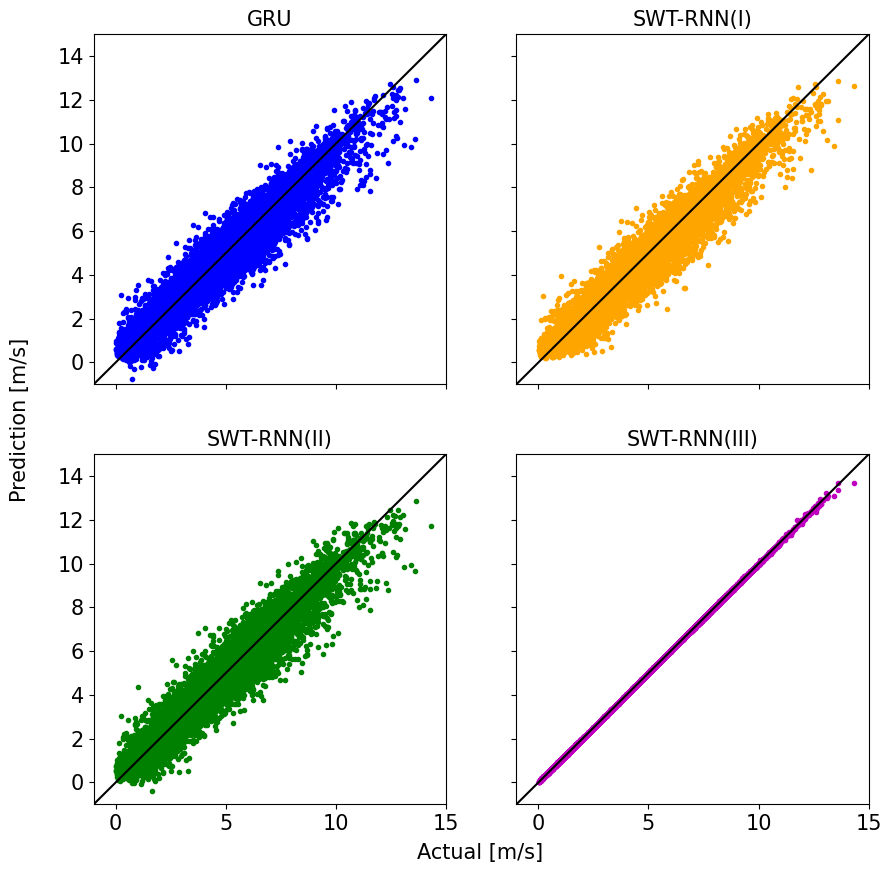

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex='all', sharey='all')
axs[0, 0].scatter(teste_y.reshape(len(teste_y))[:], model_GRU_simple_predict_y.reshape(len(teste_y))[:], marker='.', color='b')
axs[0, 1].scatter(teste_y.reshape(len(teste_y))[:], predict_y.reshape(len(teste_y))[:], marker='.', color='orange')
axs[1, 0].scatter(teste_y.reshape(len(teste_y))[:], model_WTGRU_WT_original_predict_y.reshape(len(teste_y))[:], marker='.', color='g')
axs[1, 1].scatter(teste_y.reshape(len(teste_y))[:-1],predict_y_model_SWT_all_signal.reshape(len(teste_y)-1)[:], marker='.', color='m')

_ = axs[0,0].plot([-1, 15], [-1, 15], color='black')
_ = axs[0,1].plot([-1, 15], [-1, 15], color='black')
_ = axs[1,0].plot([-1, 15], [-1, 15], color='black')
_ = axs[1,1].plot([-1, 15], [-1, 15], color='black')

axs[0, 0].set_xlim([-1,15])
axs[0, 0].set_ylim([-1,15])
axs[0, 1].set_xlim([-1,15])
axs[0, 1].set_ylim([-1,15])
axs[1, 0].set_xlim([-1,15])
axs[1, 0].set_ylim([-1,15])
axs[1, 1].set_xlim([-1,15])
axs[1, 1].set_ylim([-1,15])
axs[0, 0].tick_params(axis='both', which='major', labelsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
axs[1, 1].tick_params(axis='both', which='major', labelsize=15)

axs[0,0].set_title('GRU', fontsize='15')
axs[0,1].set_title('SWT-RNN(I)', fontsize='15')
axs[1,0].set_title('SWT-RNN(II)', fontsize='15')
axs[1,1].set_title('SWT-RNN(III)', fontsize='15')

plt.text(-5.5, -3.5 , 'Actual [m/s]', fontsize='15')
plt.text(-24, 13 , 'Prediction [m/s]', rotation=90, fontsize='15')


In [ ]:
from scipy.stats import skew
skew(disterro_C)

In [ ]:
teste_x_SWT_all_signal.shape

(55833, 128, 6)

In [ ]:
128+48

176

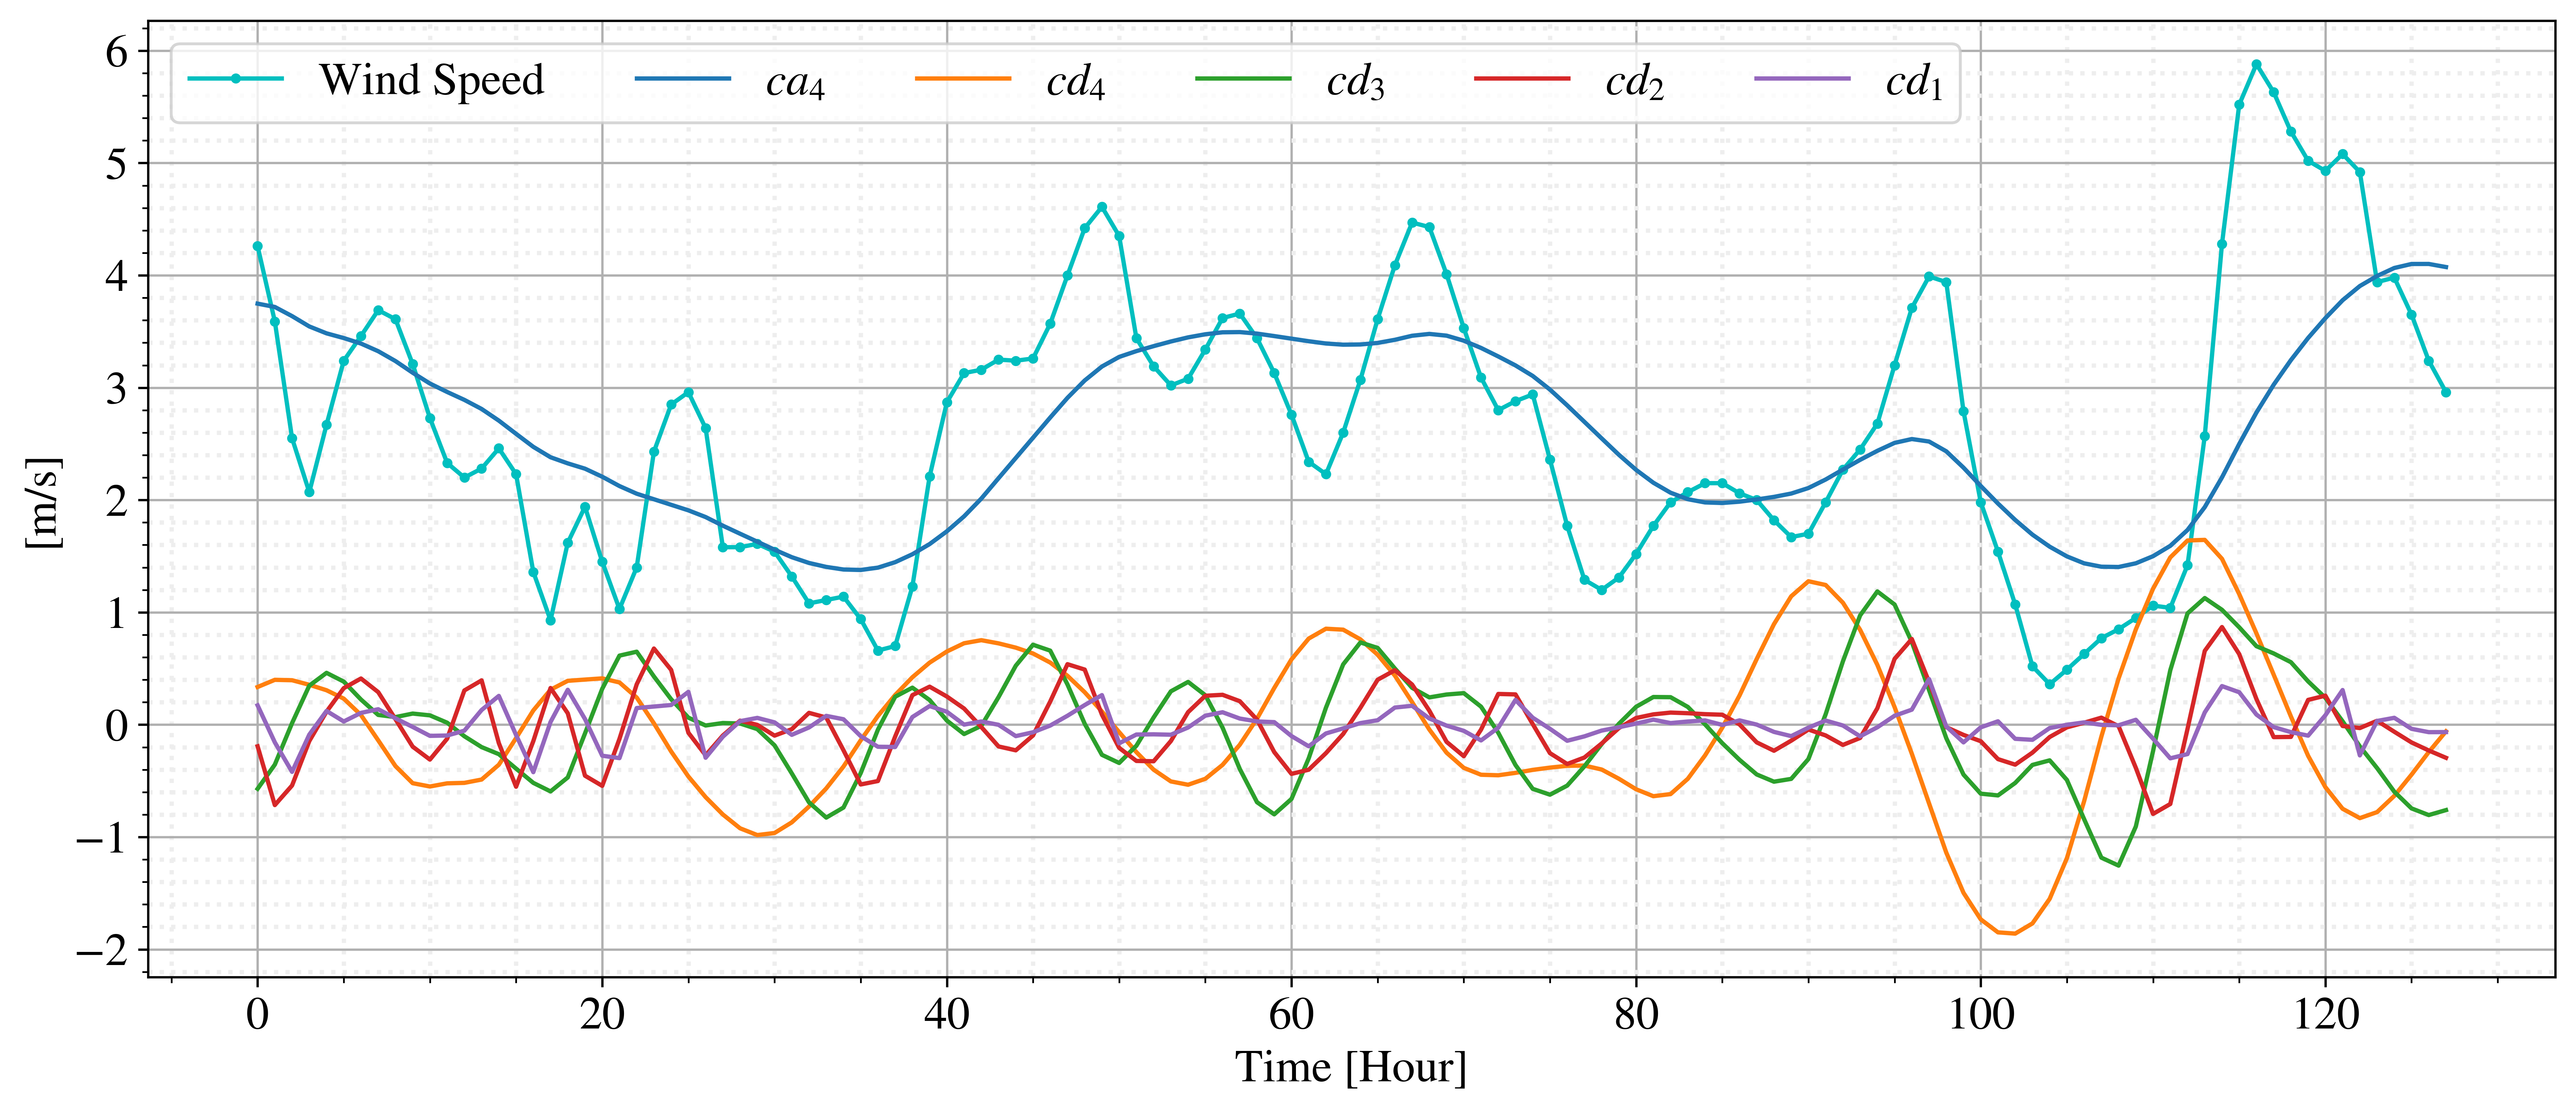

In [ ]:
plt.figure(figsize=(15, 6), dpi=600)
plt.plot(range(0,128), teste_x_SWT_all_signal[49,:,0], color='c', marker='.', markersize=5)
plt.plot(range(0,128), teste_x_SWT_all_signal[49,:,1])
plt.plot(range(0,128), teste_x_SWT_all_signal[49,:,2])
plt.plot(range(0,128), teste_x_SWT_all_signal[49,:,3])
plt.plot(range(0,128), teste_x_SWT_all_signal[49,:,4])
plt.plot(range(0,128), teste_x_SWT_all_signal[49,:,5])

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.legend(['Wind Speed', '$ca_4$', '$cd_4$', '$cd_3$', '$cd_2$', '$cd_1$'], fontsize=16, loc='upper left', ncol=6)
plt.xlabel('Time [Hour]', fontsize=16)
plt.ylabel('[m/s]', fontsize=16)

plt.minorticks_on()
plt.grid(True, which='major')
plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=1.5)
plt.tick_params(axis='both', which='major', labelsize=16)


In [ ]:
teste_x_with_original[49,:,5]

array([4.26, 3.59, 2.55, 2.07, 2.67, 3.24, 3.46, 3.69, 3.61, 3.21, 2.73,
       2.33, 2.2 , 2.28, 2.46, 2.23, 1.36, 0.93, 1.62, 1.94, 1.45, 1.03,
       1.4 , 2.43, 2.85, 2.96, 2.64, 1.58, 1.58, 1.61, 1.54, 1.32, 1.08,
       1.11, 1.14, 0.94, 0.66, 0.7 , 1.23, 2.21, 2.87, 3.13, 3.16, 3.25,
       3.24, 3.26, 3.57, 4.  , 4.42, 4.61, 4.35, 3.44, 3.19, 3.02, 3.08,
       3.34, 3.62, 3.66, 3.44, 3.13, 2.76, 2.34, 2.23, 2.6 , 3.07, 3.61,
       4.09, 4.47, 4.43, 4.01, 3.53, 3.09, 2.8 , 2.88, 2.94, 2.36, 1.77,
       1.29, 1.2 , 1.31, 1.52, 1.77, 1.98, 2.07, 2.15, 2.15, 2.06, 2.  ,
       1.82, 1.67, 1.7 , 1.98, 2.27, 2.45, 2.68, 3.2 , 3.71, 3.99, 3.94,
       2.79, 1.98, 1.54, 1.07, 0.52, 0.36, 0.49, 0.63, 0.77, 0.85, 0.95,
       1.06, 1.04, 1.42, 2.57, 4.28, 5.52, 5.88, 5.63, 5.28, 5.02, 4.93,
       5.08, 4.92, 3.94, 3.98, 3.65, 3.24, 2.96])

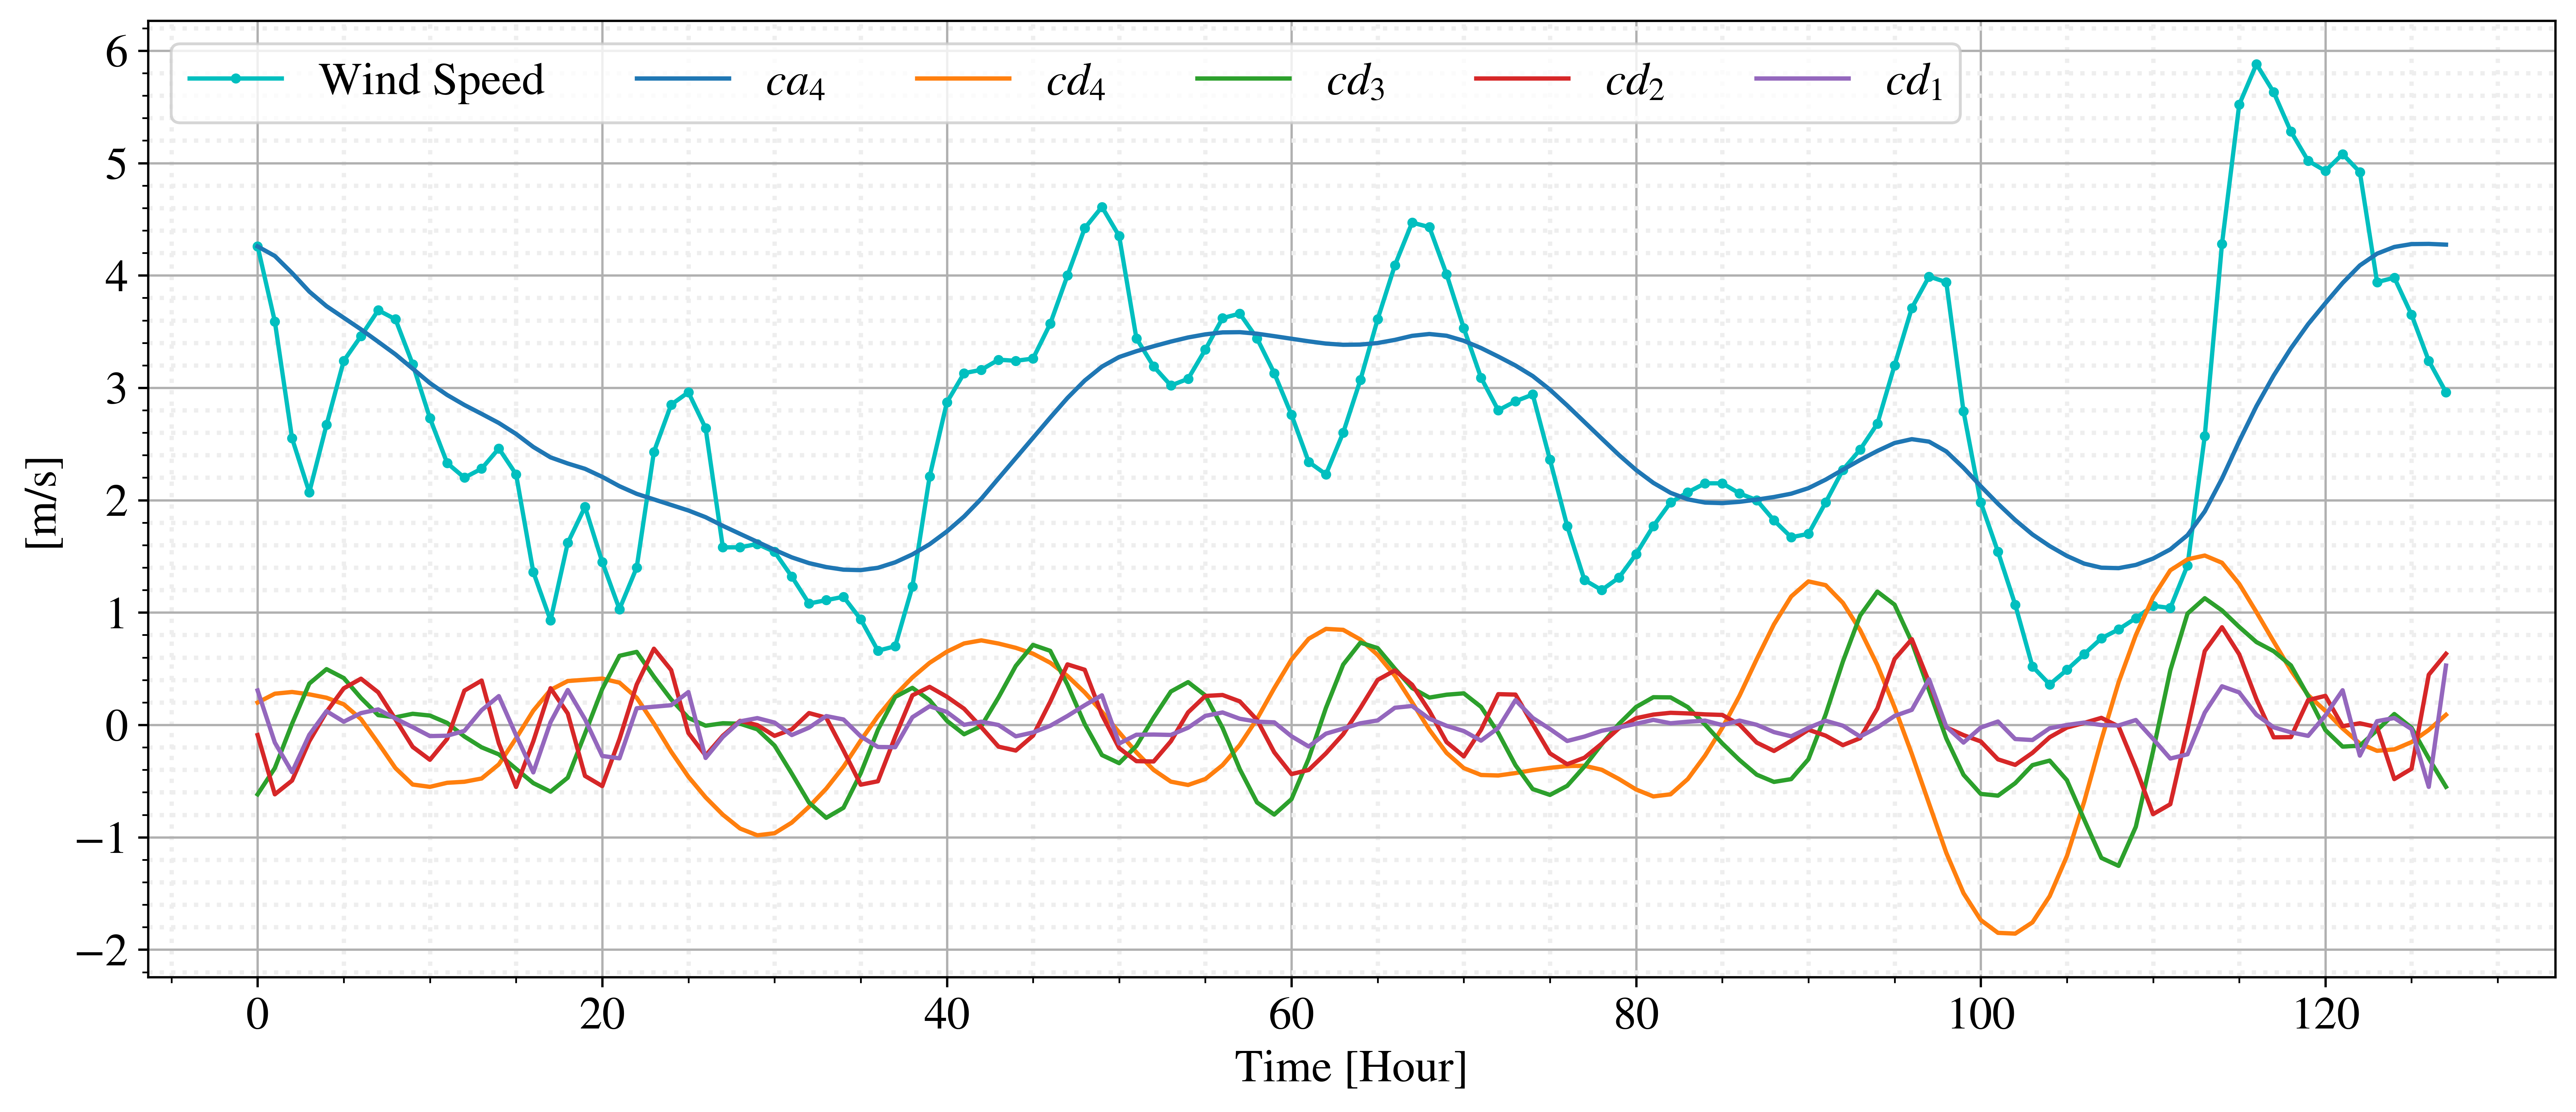

In [ ]:
plt.figure(figsize=(15, 6), dpi=600)
plt.plot(range(0,128), teste_x_with_original[49,:,5], color='c', marker='.', markersize=5)
plt.plot(range(0,128), teste_x_with_original[49,:,0])
plt.plot(range(0,128), teste_x_with_original[49,:,1])
plt.plot(range(0,128), teste_x_with_original[49,:,2])
plt.plot(range(0,128), teste_x_with_original[49,:,3])
plt.plot(range(0,128), teste_x_with_original[49,:,4])

plt.legend(['Wind Speed', '$ca_4$', '$cd_4$', '$cd_3$', '$cd_2$', '$cd_1$'], fontsize=16, loc='upper left', ncol=6)
plt.xlabel('Time [Hour]', fontsize=16)
plt.ylabel('[m/s]', fontsize=16)

plt.minorticks_on()
plt.grid(True, which='major')
plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=1.5)
plt.tick_params(axis='both', which='major', labelsize=16)